## KAN RL

In [ ]:
!pip install moviepy~=1.0.3 gymnasium pykan~=0.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 48.6 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=d2cb3c2eea173221d93ce1042858d5f3075952c783a7b51f7f5f2415467bdf80
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


## Models

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5806644.93it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 152248.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1450389.62it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 1907150.74it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

State shape: torch.Size([1, 8, 8])
Label: tensor(8)
Feedback shape: torch.Size([1, 8, 8])


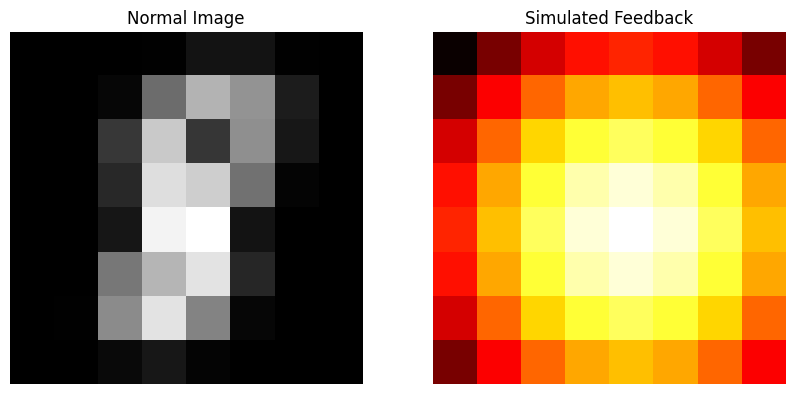

tensor(0.5273) tensor(1.)


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py  for normalization values computation

class BenchmarkEnvironment:
    def __init__(self, dataset_name='MNIST', batch_size=128, image_size=(8, 8), feedback_sigma=5.0):
        self.batch_size = batch_size
        self.image_size = image_size
        self.feedback_sigma = feedback_sigma
        self.num_channels = 1  # Force single channel for all datasets

        if dataset_name == 'MNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            self.dataset = datasets.MNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'FashionMNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR10':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Pad(4),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR10('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR100':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Pad(4),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)),
                #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR100('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'SVHN':
            self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)),
                #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.SVHN('./data', split='train', download=True, transform=self.transform)

        elif dataset_name == 'KMNIST':
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.dataset = datasets.KMNIST('./data', train=True, download=True, transform=self.transform)

        else:
            raise ValueError(f"Dataset {dataset_name} is not supported.")


        self.loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        self.iterator = iter(self.loader)
        self.reset()

    def reset(self):
        try:
            self.current_batch = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            self.current_batch = next(self.iterator)
        self.idx = 0

    def step(self):
        images, labels = self.current_batch
        if self.idx >= len(images):
            self.reset()
            return self.step()
        state = images[self.idx]
        label = labels[self.idx]
        feedback = self.generate_simulated_feedback(state.unsqueeze(0))
        self.idx += 1
        return state, label, feedback


    def generate_simulated_feedback(self, image_tensor):
        # If the image has 3 channels (RGB), average them into a single channel
        if image_tensor.shape[1] == 3:  # Check if there are 3 channels (RGB)
            image_np = image_tensor.mean(dim=1).squeeze().numpy()  # Average across channels
        else:  # For grayscale or single-channel images
            image_np = image_tensor.squeeze().numpy()

        # Normalize the image to [0, 1]
        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        # Calculate the center of mass
        center_of_mass = np.array(np.unravel_index(np.argmax(image_np), image_np.shape[-2:]))

        # Generate a Gaussian feedback mask based on the center of mass
        x, y = np.meshgrid(np.arange(image_np.shape[-1]), np.arange(image_np.shape[-2]))
        gaussian_mask = np.exp(-((x - center_of_mass[1])**2 + (y - center_of_mass[0])**2) / (2 * self.feedback_sigma**2))

        # Normalize the feedback mask
        feedback = gaussian_mask / np.max(gaussian_mask)

        # Return the feedback as a tensor
        return torch.tensor(feedback, dtype=torch.float32).view(1, *feedback.shape)

def plot_images(normal_image, feedback_image):
    # Convert tensors to numpy arrays
    normal_image_np = normal_image.squeeze().numpy()
    feedback_image_np = feedback_image.squeeze().numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Check if the normal image has 3 channels (RGB)
    if normal_image_np.ndim == 3 and normal_image_np.shape[0] == 3:  # RGB image
        # Transpose to (height, width, channels) for imshow
        normal_image_np = normal_image_np.transpose(1, 2, 0)
        axes[0].imshow(normal_image_np)
    else:  # Grayscale image
        axes[0].imshow(normal_image_np, cmap='gray')

    axes[0].set_title('Normal Image')
    axes[0].axis('off')

    # Plot feedback image (assumed to be single-channel, displayed with 'hot' colormap)
    axes[1].imshow(feedback_image_np, cmap='hot')
    axes[1].set_title('Simulated Feedback')
    axes[1].axis('off')

    plt.show()


# Example usage:
if __name__ == "__main__":
    env = BenchmarkEnvironment(dataset_name='MNIST', batch_size=128, feedback_sigma=5.0)
    state, label, feedback = env.step()
    print("State shape:", state.shape)
    print("Label:", label)
    print("Feedback shape:", feedback.shape)
    plot_images(state, feedback)
    print(feedback.min(), feedback.max())


In [ ]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.optim.lr_scheduler import ExponentialLR

class FSNet(nn.Module):
    def __init__(self, input_shape, num_filters, num_conv_layers=3, hidden_dim=128, distribution=None, tau=1.0):
        super(FSNet, self).__init__()

        self.distribution = distribution
        self.global_step = 0
        self.initial_tau = tau
        self.tau_decay = 0.96  # Exponential decay rate

        layers = []
        in_channels = input_shape[0]
        channels = []

        for i in range(num_conv_layers):
            num_filters *= 2
            channels.append(num_filters)

        for i in range(num_conv_layers):
            # For a convolutional layer to keep the input and output shapes the same: P = (K-1)/2 with S = 1
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channels[i], kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU())
            # Each MaxPool2d layer with kernel size 2 and stride 2 will halve the height and width of the feature maps.
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = channels[i]

        layers.append(nn.Flatten())
        self.feature_extractor = nn.Sequential(*layers)

        # Dummy forward pass to determine the output size of the feature extractor
        dummy_input = torch.empty(1, *input_shape)
        n_features = self.feature_extractor(dummy_input).shape[1]
        # print(n_features)

        self.fc1 = nn.Linear(n_features, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_dim, n_features)
        self.sigmoid = nn.Sigmoid()
        # self.softmax = nn.Softmax(dim=-1)

        # Storage for probabilities and feedback costs
        self.probs_history = []
        self.feedback_cost_history = []


    def forward(self, x, feedback=None, epoch=0, n_epochs=None):
        x = x.view(-1, input_shape[0], input_shape[1], input_shape[2])
        features = self.feature_extractor(x)

        x = self.relu(self.fc1(features))
        probs_logits = self.relu(self.fc2(x))
        probs = self.sigmoid(probs_logits)

        # Apply the simulated feedback as a weight to the feature selection
        if feedback is None:
            feedback = probs # so that mse_loss becomes 0 if no feedback is fed
        else:
            pass

        # Use distribution as weight of the features
        if self.distribution == 'bernoulli':
            mask = torch.distributions.Bernoulli(logits=probs_logits)
            sample_probs = mask.sample()
        if self.distribution == 'gumbel_softmax':
            tau = self.initial_tau * (self.tau_decay ** epoch)
            mask = F.gumbel_softmax(logits=probs_logits, tau=tau, hard=False)
            sample_probs = mask
        if self.distribution == 'gaussian':
            mu = probs_logits  # or some transformation of probs_logits
            sigma = torch.ones_like(mu)  # Standard deviation
            gaussian_dist = torch.distributions.Normal(mu, sigma)
            sample_probs = gaussian_dist.rsample()  # Use rsample for the reparameterization trick
        if self.distribution == 'beta':
            alpha = F.softplus(probs_logits) + 1
            beta = F.softplus(probs_logits) + 1
            beta_dist = torch.distributions.Beta(alpha, beta)
            sample_probs = beta_dist.sample()
        if self.distribution == 'dirichlet':
            concentration = F.softplus(probs_logits) + 1  # Ensuring positive values
            dirichlet_dist = torch.distributions.Dirichlet(concentration)
            sample_probs = dirichlet_dist.sample()
        elif self.distribution == 'multinomial':
            logits = probs_logits  # Logits for the multinomial distribution
            mask = torch.distributions.Multinomial(logits=logits)
            sample_probs = mask.sample()
        elif self.distribution == 'laplace':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            laplace_dist = torch.distributions.Laplace(loc, scale)
            sample_probs = laplace_dist.sample()
        elif self.distribution == 'cauchy':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            cauchy_dist = torch.distributions.Cauchy(loc, scale)
            sample_probs = cauchy_dist.sample()
        elif self.distribution == 'uniform':
            low = torch.zeros_like(probs_logits)  # Lower bound
            high = torch.ones_like(probs_logits)  # Upper bound
            uniform_dist = torch.distributions.Uniform(low, high)
            sample_probs = uniform_dist.sample()

        # print(sample_probs.shape)

        feedback_cost = F.mse_loss(probs, feedback)

        flat_zoom_X = features * sample_probs

        return flat_zoom_X, feedback_cost, probs


# Example usage:
input_shape = (1, 8, 8)  # Change this to the desired input shape
num_conv_layers = 1  # Specify the desired number of convolutional layers
num_filters = 2 # [2,4], [3,8]
model = FSNet(input_shape, num_filters, num_conv_layers, hidden_dim=128, distribution='uniform')
print(model)

# Test with an example input
example_input = torch.randn(*input_shape)

# print(flat_zoom_X, probs)
# print(flat_zoom_X.shape[1])
flat_zoom_X, feedback_cost, probs = model.forward(example_input)
print(flat_zoom_X.shape)

FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
)
torch.Size([1, 64])


In [ ]:
# @title
from collections import deque
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from kan import KAN
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Callable, Union

class ReplayBuffer:
    def __init__(self, capacity, observation_dim):
        self.capacity = capacity
        self.observations = torch.zeros(capacity, observation_dim)
        self.actions = torch.zeros(capacity, 1, dtype=torch.int64)
        self.next_observations = torch.zeros(capacity, observation_dim)
        self.rewards = torch.zeros(capacity, 1)
        self.terminations = torch.zeros(capacity, 1, dtype=torch.int)
        self.cursor = 0

    def add(self, observation, action, next_observation, reward, termination):
        index = self.cursor % self.capacity
        self.observations[index] = observation
        self.actions[index] = action
        self.next_observations[index] = next_observation
        self.rewards[index] = reward
        self.terminations[index] = termination
        self.cursor += 1

    def sample(self, batch_size):
        idx = np.random.permutation(np.arange(len(self)))[:batch_size]
        return (
            self.observations[idx],
            self.actions[idx],
            self.next_observations[idx],
            self.rewards[idx],
            self.terminations[idx],
        )

    def __len__(self):
        return min(self.cursor, self.capacity)



def kan_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    lamb=0.0,
    lamb_l1=1.0,
    lamb_entropy=2.0,
    lamb_coef=0.0,
    lamb_coefdiff=0.0,
    small_mag_threshold=1e-16,
    small_reg_factor=1.0,
    feedback_cost=None,
    feature_selection=False,
):


    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.0
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(
                -1,
            )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(net.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(net.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(
                torch.mean(torch.abs(torch.diff(net.act_fun[i].coef)), dim=1)
            )
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )


    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    # loss = criterion(td_target, old_val)
    reg_ = reg(net.acts_scale)
    loss = criterion(td_target, old_val) + lamb * reg_

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
        combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
        combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()

def mlp_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    feedback_cost=None,
    feature_selection=False,
):
    observations, actions, next_observations, rewards, terminations = data

    # Compute everything related to primary loss in a single block to retain the graph
    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )

    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    loss = criterion(td_target, old_val)

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
      combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
      combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)



2024-10-31 19:35:55.680377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 19:35:55.680535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 19:35:55.840466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# @title
import os
import time
import random
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm

def kanRL(config):
      set_all_seeds(config["seed"])
      env = BenchmarkEnvironment(dataset_name='MNIST', batch_size=config["batch_size"], feedback_sigma=5.0)    #MNISTEnvironment(config["batch_size"])
      results_dir = 'results'

      # Check if the directory exists before trying to delete it
      # if os.path.exists(results_dir) and os.path.isdir(results_dir):
      #     shutil.rmtree(results_dir)
      #     print(f"Directory '{results_dir}' has been deleted.")
      # else:
      #     print(f"Directory '{results_dir}' does not exist.")

      input_shape = (config['first_channel'], int(config['input_size']**0.5), int(config['input_size']**0.5))  # Change this to the desired input shape
      print(input_shape)
      agent = FSNet(input_shape, config['num_filters'], config['num_conv_layers'], config['hidden_dim'], distribution=config['distribution'], tau=config['initial_tau'])
      print(agent)

      if config["feature_selection"] == True:
          example_input = torch.randn(*input_shape)
          features, _, _ = agent(example_input)
          n_features = features.shape[1]
          print(n_features)
      else:
          n_features = config["input_size"]

      if config["method"] == "KAN":
          q_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          target_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          train = kan_train
      elif config["method"] == "MLP":
          q_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          target_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          train = mlp_train
      else:
          raise Exception(
              f"Method {config['method']} doesn't exist, choose between MLP and KAN."
          )

      target_network.load_state_dict(q_network.state_dict())

      run_name = f"{config['method']}_SVHN_{config['seed']}_{int(time.time())}"

      writer = SummaryWriter(f"runs/{run_name}")

      os.makedirs("results", exist_ok=True)
      with open(f"results/{run_name}.csv", "w") as f:
          f.write("epoch,accuracy\n")


      optimizer = optim.Adam(list(agent.parameters())+list(q_network.parameters()), lr = config["learning_rate"], weight_decay = config["weight_decay"])
      # Define learning rate scheduler
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

      writer.add_text(
          "hyperparameters",
          "|param|value|\n|-|-|\n%s"
          % ("\n".join([f"|{key}|{value}|" for key, value in config.items()])),
      )

      replay_buffer = ReplayBuffer(config["buffer_size"], n_features) # change here if the input size changes

      train_accuracies = []
      test_accuracies = []
      train_acc_stds = []
      test_acc_stds = []
      episode_lengths = []
      losses = []
      loss_stds = []
      probs_history = []
      feedback_cost_history = []

      # Training phase
      for epoch in tqdm(range(config["n_epochs"]), desc=f"{run_name}"):
          running_loss = 0.0
          correct = 0
          total = 0
          probs_batch_list = []
          feedback_cost_tot = 0

          for _ in range(len(env.loader)):
              state, label, feedback = env.step()
              feedback = feedback.view(-1, config['input_size'])

              if config["feature_selection"] == True:
                  flat_zoom_X, feedback_cost, probs = agent.forward(state, feedback, epoch, config["n_epochs"])
                  # Collect the probabilities and feedback costs
                  probs_batch_list.append(probs.detach().cpu().numpy())
                  feedback_cost_tot += feedback_cost.detach().cpu().numpy()
                  # Calculate regularization loss
                  state = flat_zoom_X
              else:
                  state = state.view(-1, config['input_size'])
                  probs_batch_list.append(torch.zeros((1, int(config['input_size']))))
                  probs = torch.zeros((1, int(config['input_size'])))
                  feedback_cost = torch.zeros(1)
                  feedback_cost_tot += torch.zeros(1)

              # Forward pass
              if epoch < config["warm_up_episodes"]:
                  action = torch.tensor([random.randint(0, 9)])
              else:
                  with torch.no_grad():
                      action = q_network(state).argmax(axis=-1).squeeze().item()

              reward = torch.tensor([1.0]) if action == label else torch.tensor([0.0])
              next_state, next_label, _ = env.step()
              if config["feature_selection"] == True:
                  next_state, _, _ = agent.forward(next_state)
              else:
                  next_state = next_state.view(-1, config['input_size'])

              replay_buffer.add(state, action, next_state, reward, torch.tensor([1]))

              if len(replay_buffer) > config["batch_size"]:
                  batch = replay_buffer.sample(config["batch_size"])
                  loss = train(
                      q_network,
                      target_network,
                      batch,
                      optimizer,
                      gamma=config["gamma"],
                      feedback_cost = feedback_cost,
                      feature_selection = config['feature_selection'],
                  )
                  running_loss += loss

              correct += (action == label).sum().item()
              total += 1

          scheduler.step()
          print()
          print('correct:', correct, 'total:', total)
          print('loss:', running_loss/total)
          train_accuracy = correct / total
          print(' Train accuracy: ', train_accuracy, '| ')
          train_accuracies.append(train_accuracy)
          losses.append(running_loss/total)

          # Aggregate probabilities by averaging across the batch
          avg_probs = np.mean(np.array(probs_batch_list), axis=0)
          probs_history.append(avg_probs)
          # Compute feedback cost
          feedback_cost_history.append(feedback_cost_tot / len(env.loader))

          if (
              epoch % 25 == 0
              and config["method"] == "KAN"
              and epoch < int(config["n_epochs"] * (1 / 2))
          ):
              q_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])
              target_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])

          if epoch % config["target_update"] == 0:
              target_network.load_state_dict(q_network.state_dict())


          correct = 0
          total = 0
          with torch.no_grad():
                  # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
                  # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
                  # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
                  # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
                  # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)), # SVHN
              for images, labels in DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
                                                             #split='test', download=True, transform=transforms.Compose([
                                                             #train=False, download=True, transform=transforms.Compose([
                  transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
                  transforms.ToTensor(),
                  transforms.Normalize((0.1307,), (0.3081,)) # MNIST
                  #transforms.Grayscale(num_output_channels=1)
              ])), batch_size=config["batch_size"]):
                  state = images.view(-1,config["input_size"])

                  if config["feature_selection"] == True:
                      flat_zoom_X, _, _ = agent(state)
                      state = flat_zoom_X

                  outputs = q_network(state)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

          test_accuracy = correct / total
          print(' Test accuracy: ', test_accuracy)
          test_accuracies.append(test_accuracy)

          writer.add_scalar("Loss/train", running_loss / total, epoch)
          writer.add_scalar("Accuracy/train", train_accuracy, epoch)
          writer.add_scalar("Accuracy/test", test_accuracy, epoch)

          with open(f"results/{run_name}.csv", "a") as f:
              f.write(f"{epoch},{test_accuracy}\n")


      # Calculate standard deviations
      train_acc_stds = [np.std(train_accuracies[max(0, i-10):i+1]) for i in range(len(train_accuracies))]
      test_acc_stds = [np.std(test_accuracies[max(0, i-10):i+1]) for i in range(len(test_accuracies))]
      loss_stds = [np.std(losses[max(0, i-10):i+1]) for i in range(len(losses))]

      epochs = np.arange(len(train_accuracies))

      #### With uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.fill_between(epochs, np.array(train_accuracies) - np.array(train_acc_stds), np.array(train_accuracies) + np.array(train_acc_stds), alpha=0.3)
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.fill_between(epochs, np.array(test_accuracies) - np.array(test_acc_stds), np.array(test_accuracies) + np.array(test_acc_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.fill_between(epochs, np.array(losses) - np.array(loss_stds), np.array(losses) + np.array(loss_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()


      ##### Without uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()

      # Print final accuracy with +/- error
      final_train_accuracy = train_accuracies[-1]
      final_train_acc_std = train_acc_stds[-1]
      final_test_accuracy = test_accuracies[-1]
      final_test_acc_std = test_acc_stds[-1]

      print(f"Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
      print(f"Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")


      return q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent


In [ ]:

# config = {
#     "batch_size": 128,
#     "n_epochs": 5,
#     "gamma": 0.8,
#     "learning_rate": 1e-3, # 0.0005
#     "weight_decay": 1e-4,
#     "width": 8,
#     "grid": 3,
#     "method": "KAN",  # "MLP", "KAN"
#     "seed": 0,
#     "input_size": 8 * 8, # number of features
#     "output_size": 10, # number of classes
#     "buffer_size": 100000,
#     "target_update": 10,
#     "warm_up_episodes": 2,
#     "num_filters": 4,
#     "num_conv_layers": 2,
#     "first_channel": 1, # (1,8,8)
#     "hidden_dim": 128,
#     "feature_selection": True,
#     "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
#     "initial_tau": 1.0, # positive float value

# }

# q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 1, 3, 5], input_shape=(1, 8, 8)):
#     # Determine the side length of the image
#     side_length = int(np.sqrt(probs_history[0].shape[1]))

#     fig, axes = plt.subplots(2, 2, figsize=(12, 8))

#     for i, epoch in enumerate(epochs):
#         ax = axes[i // 2, i % 2]
#         if epoch < len(probs_history):
#             probs = probs_history[epoch].flatten()
#             if side_length ** 2 != probs.shape[0]:
#                 continue
#             probs_image = probs.reshape((side_length, side_length))
#             cax = ax.matshow(probs_image, cmap='viridis')
#             fig.colorbar(cax, ax=ax)
#             ax.set_title(f'Probabilities at Epoch {epoch}')
#         else:
#             ax.axis('off')

#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(10, 5))
#     plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
#     plt.xlabel('Epoch')
#     plt.ylabel('Feedback Cost')
#     plt.title('Evolution of Feedback Cost (MSE)')
#     plt.legend()
#     plt.show()


# plot_evolution(probs_history, feedback_cost_history)


# MLP

In [ ]:
!pip install torchview

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
)
64


MLP_SVHN_0_1730403379:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.05425813673401692
 Train accuracy:  0.09381663113006397 | 


MLP_SVHN_0_1730403379:   1%|          | 1/100 [00:04<07:27,  4.52s/it]

 Test accuracy:  0.4044

correct: 48 total: 469
loss: 0.06440068875898176
 Train accuracy:  0.1023454157782516 | 


MLP_SVHN_0_1730403379:   2%|▏         | 2/100 [00:09<07:30,  4.60s/it]

 Test accuracy:  0.5342

correct: 281 total: 469
loss: 0.0742658834848831
 Train accuracy:  0.5991471215351812 | 


MLP_SVHN_0_1730403379:   3%|▎         | 3/100 [00:13<07:30,  4.64s/it]

 Test accuracy:  0.6268

correct: 313 total: 469
loss: 0.08317595858500203
 Train accuracy:  0.6673773987206824 | 


MLP_SVHN_0_1730403379:   4%|▍         | 4/100 [00:18<07:32,  4.71s/it]

 Test accuracy:  0.6798

correct: 339 total: 469
loss: 0.08633276429384756
 Train accuracy:  0.7228144989339019 | 


MLP_SVHN_0_1730403379:   5%|▌         | 5/100 [00:23<07:30,  4.74s/it]

 Test accuracy:  0.7011

correct: 326 total: 469
loss: 0.08887729747717314
 Train accuracy:  0.6950959488272921 | 


MLP_SVHN_0_1730403379:   6%|▌         | 6/100 [00:28<07:26,  4.75s/it]

 Test accuracy:  0.7283

correct: 345 total: 469
loss: 0.09067533911863115
 Train accuracy:  0.7356076759061834 | 


MLP_SVHN_0_1730403379:   7%|▋         | 7/100 [00:33<07:24,  4.78s/it]

 Test accuracy:  0.7429

correct: 335 total: 469
loss: 0.0922000366709888
 Train accuracy:  0.7142857142857143 | 


MLP_SVHN_0_1730403379:   8%|▊         | 8/100 [00:37<07:21,  4.80s/it]

 Test accuracy:  0.7577

correct: 350 total: 469
loss: 0.09368960505355396
 Train accuracy:  0.746268656716418 | 


MLP_SVHN_0_1730403379:   9%|▉         | 9/100 [00:42<07:23,  4.88s/it]

 Test accuracy:  0.7652

correct: 342 total: 469
loss: 0.09454558430704227
 Train accuracy:  0.7292110874200426 | 


MLP_SVHN_0_1730403379:  10%|█         | 10/100 [00:47<07:19,  4.88s/it]

 Test accuracy:  0.7732

correct: 339 total: 469
loss: 0.09534476144608658
 Train accuracy:  0.7228144989339019 | 


MLP_SVHN_0_1730403379:  11%|█         | 11/100 [00:52<07:16,  4.90s/it]

 Test accuracy:  0.7795

correct: 377 total: 469
loss: 0.09568735342353646
 Train accuracy:  0.8038379530916845 | 


MLP_SVHN_0_1730403379:  12%|█▏        | 12/100 [00:57<07:17,  4.97s/it]

 Test accuracy:  0.7861

correct: 352 total: 469
loss: 0.09658736438512294
 Train accuracy:  0.7505330490405118 | 


MLP_SVHN_0_1730403379:  13%|█▎        | 13/100 [01:02<07:14,  4.99s/it]

 Test accuracy:  0.7806

correct: 363 total: 469
loss: 0.09737763541148924
 Train accuracy:  0.7739872068230277 | 


MLP_SVHN_0_1730403379:  14%|█▍        | 14/100 [01:08<07:11,  5.01s/it]

 Test accuracy:  0.7853

correct: 353 total: 469
loss: 0.09703509598525602
 Train accuracy:  0.7526652452025586 | 


MLP_SVHN_0_1730403379:  15%|█▌        | 15/100 [01:13<07:07,  5.03s/it]

 Test accuracy:  0.7986

correct: 367 total: 469
loss: 0.09698584475624028
 Train accuracy:  0.7825159914712153 | 


MLP_SVHN_0_1730403379:  16%|█▌        | 16/100 [01:18<07:03,  5.04s/it]

 Test accuracy:  0.8015

correct: 381 total: 469
loss: 0.09675237904987864
 Train accuracy:  0.8123667377398721 | 


MLP_SVHN_0_1730403379:  17%|█▋        | 17/100 [01:23<06:59,  5.06s/it]

 Test accuracy:  0.8009

correct: 376 total: 469
loss: 0.09742023308139874
 Train accuracy:  0.8017057569296375 | 


MLP_SVHN_0_1730403379:  18%|█▊        | 18/100 [01:28<07:00,  5.13s/it]

 Test accuracy:  0.7992

correct: 359 total: 469
loss: 0.09754289558002435
 Train accuracy:  0.7654584221748401 | 


MLP_SVHN_0_1730403379:  19%|█▉        | 19/100 [01:33<06:54,  5.12s/it]

 Test accuracy:  0.8005

correct: 379 total: 469
loss: 0.09717158302823618
 Train accuracy:  0.8081023454157783 | 


MLP_SVHN_0_1730403379:  20%|██        | 20/100 [01:38<06:47,  5.10s/it]

 Test accuracy:  0.8099

correct: 375 total: 469
loss: 0.09785772056213574
 Train accuracy:  0.7995735607675906 | 


MLP_SVHN_0_1730403379:  21%|██        | 21/100 [01:43<06:40,  5.08s/it]

 Test accuracy:  0.8077

correct: 389 total: 469
loss: 0.09831000623037058
 Train accuracy:  0.8294243070362474 | 


MLP_SVHN_0_1730403379:  22%|██▏       | 22/100 [01:48<06:32,  5.03s/it]

 Test accuracy:  0.8113

correct: 377 total: 469
loss: 0.09776700810709996
 Train accuracy:  0.8038379530916845 | 


MLP_SVHN_0_1730403379:  23%|██▎       | 23/100 [01:53<06:24,  5.00s/it]

 Test accuracy:  0.8143

correct: 361 total: 469
loss: 0.09758268755826868
 Train accuracy:  0.7697228144989339 | 


MLP_SVHN_0_1730403379:  24%|██▍       | 24/100 [01:58<06:21,  5.03s/it]

 Test accuracy:  0.8106

correct: 393 total: 469
loss: 0.0972819586139498
 Train accuracy:  0.837953091684435 | 


MLP_SVHN_0_1730403379:  25%|██▌       | 25/100 [02:03<06:16,  5.02s/it]

 Test accuracy:  0.8149

correct: 375 total: 469
loss: 0.09718152718630427
 Train accuracy:  0.7995735607675906 | 


MLP_SVHN_0_1730403379:  26%|██▌       | 26/100 [02:08<06:12,  5.04s/it]

 Test accuracy:  0.8047

correct: 366 total: 469
loss: 0.09774977041841316
 Train accuracy:  0.7803837953091685 | 


MLP_SVHN_0_1730403379:  27%|██▋       | 27/100 [02:13<06:07,  5.03s/it]

 Test accuracy:  0.8156

correct: 384 total: 469
loss: 0.09729418476253177
 Train accuracy:  0.8187633262260128 | 


MLP_SVHN_0_1730403379:  28%|██▊       | 28/100 [02:18<06:04,  5.06s/it]

 Test accuracy:  0.8125

correct: 367 total: 469
loss: 0.0970961489339373
 Train accuracy:  0.7825159914712153 | 


MLP_SVHN_0_1730403379:  29%|██▉       | 29/100 [02:23<05:59,  5.06s/it]

 Test accuracy:  0.809

correct: 395 total: 469
loss: 0.09745450830980659
 Train accuracy:  0.8422174840085288 | 


MLP_SVHN_0_1730403379:  30%|███       | 30/100 [02:29<05:56,  5.10s/it]

 Test accuracy:  0.8137

correct: 369 total: 469
loss: 0.0968330423397296
 Train accuracy:  0.7867803837953091 | 


MLP_SVHN_0_1730403379:  31%|███       | 31/100 [02:34<05:52,  5.10s/it]

 Test accuracy:  0.8186

correct: 375 total: 469
loss: 0.09723836243915152
 Train accuracy:  0.7995735607675906 | 


MLP_SVHN_0_1730403379:  32%|███▏      | 32/100 [02:39<05:47,  5.12s/it]

 Test accuracy:  0.8206

correct: 384 total: 469
loss: 0.09769876069351555
 Train accuracy:  0.8187633262260128 | 


MLP_SVHN_0_1730403379:  33%|███▎      | 33/100 [02:44<05:41,  5.09s/it]

 Test accuracy:  0.8184

correct: 390 total: 469
loss: 0.09718555957078934
 Train accuracy:  0.8315565031982942 | 


MLP_SVHN_0_1730403379:  34%|███▍      | 34/100 [02:49<05:36,  5.10s/it]

 Test accuracy:  0.8162

correct: 366 total: 469
loss: 0.09746490768405167
 Train accuracy:  0.7803837953091685 | 


MLP_SVHN_0_1730403379:  35%|███▌      | 35/100 [02:54<05:31,  5.10s/it]

 Test accuracy:  0.8231

correct: 390 total: 469
loss: 0.09719506987948408
 Train accuracy:  0.8315565031982942 | 


MLP_SVHN_0_1730403379:  36%|███▌      | 36/100 [02:59<05:26,  5.10s/it]

 Test accuracy:  0.8219

correct: 379 total: 469
loss: 0.09831341298849089
 Train accuracy:  0.8081023454157783 | 


MLP_SVHN_0_1730403379:  37%|███▋      | 37/100 [03:05<05:26,  5.18s/it]

 Test accuracy:  0.8238

correct: 378 total: 469
loss: 0.0977839348571641
 Train accuracy:  0.8059701492537313 | 


MLP_SVHN_0_1730403379:  38%|███▊      | 38/100 [03:10<05:19,  5.16s/it]

 Test accuracy:  0.8239

correct: 371 total: 469
loss: 0.09788512390877392
 Train accuracy:  0.7910447761194029 | 


MLP_SVHN_0_1730403379:  39%|███▉      | 39/100 [03:15<05:15,  5.17s/it]

 Test accuracy:  0.8246

correct: 387 total: 469
loss: 0.09785464177253658
 Train accuracy:  0.8251599147121536 | 


MLP_SVHN_0_1730403379:  40%|████      | 40/100 [03:20<05:12,  5.21s/it]

 Test accuracy:  0.8215

correct: 387 total: 469
loss: 0.09730450275228984
 Train accuracy:  0.8251599147121536 | 


MLP_SVHN_0_1730403379:  41%|████      | 41/100 [03:26<05:10,  5.26s/it]

 Test accuracy:  0.8236

correct: 377 total: 469
loss: 0.09766946391446758
 Train accuracy:  0.8038379530916845 | 


MLP_SVHN_0_1730403379:  42%|████▏     | 42/100 [03:31<05:03,  5.23s/it]

 Test accuracy:  0.8195

correct: 390 total: 469
loss: 0.09822665288377164
 Train accuracy:  0.8315565031982942 | 


MLP_SVHN_0_1730403379:  43%|████▎     | 43/100 [03:36<05:03,  5.33s/it]

 Test accuracy:  0.8254

correct: 395 total: 469
loss: 0.09772710664185888
 Train accuracy:  0.8422174840085288 | 


MLP_SVHN_0_1730403379:  44%|████▍     | 44/100 [03:42<04:55,  5.28s/it]

 Test accuracy:  0.8273

correct: 395 total: 469
loss: 0.09825514995657814
 Train accuracy:  0.8422174840085288 | 


MLP_SVHN_0_1730403379:  45%|████▌     | 45/100 [03:47<04:48,  5.24s/it]

 Test accuracy:  0.8309

correct: 386 total: 469
loss: 0.09785769854400203
 Train accuracy:  0.8230277185501066 | 


MLP_SVHN_0_1730403379:  46%|████▌     | 46/100 [03:52<04:39,  5.17s/it]

 Test accuracy:  0.8306

correct: 380 total: 469
loss: 0.0974431850635675
 Train accuracy:  0.8102345415778252 | 


MLP_SVHN_0_1730403379:  47%|████▋     | 47/100 [03:57<04:32,  5.14s/it]

 Test accuracy:  0.8283

correct: 387 total: 469
loss: 0.09823348169832595
 Train accuracy:  0.8251599147121536 | 


MLP_SVHN_0_1730403379:  48%|████▊     | 48/100 [04:02<04:26,  5.13s/it]

 Test accuracy:  0.8256

correct: 380 total: 469
loss: 0.09834394796189469
 Train accuracy:  0.8102345415778252 | 


MLP_SVHN_0_1730403379:  49%|████▉     | 49/100 [04:07<04:26,  5.22s/it]

 Test accuracy:  0.8302

correct: 379 total: 469
loss: 0.09845788266930754
 Train accuracy:  0.8081023454157783 | 


MLP_SVHN_0_1730403379:  50%|█████     | 50/100 [04:12<04:20,  5.21s/it]

 Test accuracy:  0.8279

correct: 396 total: 469
loss: 0.0980000654771638
 Train accuracy:  0.8443496801705757 | 


MLP_SVHN_0_1730403379:  51%|█████     | 51/100 [04:18<04:14,  5.19s/it]

 Test accuracy:  0.8266

correct: 385 total: 469
loss: 0.09789321303113437
 Train accuracy:  0.8208955223880597 | 


MLP_SVHN_0_1730403379:  52%|█████▏    | 52/100 [04:23<04:05,  5.12s/it]

 Test accuracy:  0.8259

correct: 370 total: 469
loss: 0.09850127181645904
 Train accuracy:  0.7889125799573561 | 


MLP_SVHN_0_1730403379:  53%|█████▎    | 53/100 [04:28<04:00,  5.11s/it]

 Test accuracy:  0.8301

correct: 387 total: 469
loss: 0.0985393348628524
 Train accuracy:  0.8251599147121536 | 


MLP_SVHN_0_1730403379:  54%|█████▍    | 54/100 [04:33<03:58,  5.18s/it]

 Test accuracy:  0.8237

correct: 367 total: 469
loss: 0.0985515183890298
 Train accuracy:  0.7825159914712153 | 


MLP_SVHN_0_1730403379:  55%|█████▌    | 55/100 [04:38<03:55,  5.23s/it]

 Test accuracy:  0.8304

correct: 391 total: 469
loss: 0.0990920780278218
 Train accuracy:  0.8336886993603412 | 


MLP_SVHN_0_1730403379:  56%|█████▌    | 56/100 [04:43<03:48,  5.19s/it]

 Test accuracy:  0.8324

correct: 377 total: 469
loss: 0.09816591417802169
 Train accuracy:  0.8038379530916845 | 


MLP_SVHN_0_1730403379:  57%|█████▋    | 57/100 [04:49<03:42,  5.17s/it]

 Test accuracy:  0.8311

correct: 388 total: 469
loss: 0.09846155062667343
 Train accuracy:  0.8272921108742004 | 


MLP_SVHN_0_1730403379:  58%|█████▊    | 58/100 [04:54<03:36,  5.16s/it]

 Test accuracy:  0.8345

correct: 380 total: 469
loss: 0.09871494274403748
 Train accuracy:  0.8102345415778252 | 


MLP_SVHN_0_1730403379:  59%|█████▉    | 59/100 [04:59<03:32,  5.17s/it]

 Test accuracy:  0.8362

correct: 397 total: 469
loss: 0.09894208662481958
 Train accuracy:  0.8464818763326226 | 


MLP_SVHN_0_1730403379:  60%|██████    | 60/100 [05:04<03:27,  5.19s/it]

 Test accuracy:  0.837

correct: 387 total: 469
loss: 0.0984221224718765
 Train accuracy:  0.8251599147121536 | 


MLP_SVHN_0_1730403379:  61%|██████    | 61/100 [05:09<03:24,  5.24s/it]

 Test accuracy:  0.8322

correct: 376 total: 469
loss: 0.09860139433890264
 Train accuracy:  0.8017057569296375 | 


MLP_SVHN_0_1730403379:  62%|██████▏   | 62/100 [05:15<03:20,  5.29s/it]

 Test accuracy:  0.8337

correct: 381 total: 469
loss: 0.09866186997084729
 Train accuracy:  0.8123667377398721 | 


MLP_SVHN_0_1730403379:  63%|██████▎   | 63/100 [05:20<03:16,  5.32s/it]

 Test accuracy:  0.8305

correct: 390 total: 469
loss: 0.099040222431678
 Train accuracy:  0.8315565031982942 | 


MLP_SVHN_0_1730403379:  64%|██████▍   | 64/100 [05:26<03:12,  5.35s/it]

 Test accuracy:  0.8327

correct: 405 total: 469
loss: 0.09885449836185492
 Train accuracy:  0.8635394456289979 | 


MLP_SVHN_0_1730403379:  65%|██████▌   | 65/100 [05:31<03:07,  5.35s/it]

 Test accuracy:  0.8395

correct: 376 total: 469
loss: 0.0993668469252871
 Train accuracy:  0.8017057569296375 | 


MLP_SVHN_0_1730403379:  66%|██████▌   | 66/100 [05:37<03:03,  5.40s/it]

 Test accuracy:  0.8335

correct: 410 total: 469
loss: 0.09871755179756486
 Train accuracy:  0.8742004264392325 | 


MLP_SVHN_0_1730403379:  67%|██████▋   | 67/100 [05:42<03:01,  5.49s/it]

 Test accuracy:  0.8274

correct: 386 total: 469
loss: 0.09908672955943577
 Train accuracy:  0.8230277185501066 | 


MLP_SVHN_0_1730403379:  68%|██████▊   | 68/100 [05:48<02:56,  5.51s/it]

 Test accuracy:  0.8321

correct: 390 total: 469
loss: 0.09851411293183308
 Train accuracy:  0.8315565031982942 | 


MLP_SVHN_0_1730403379:  69%|██████▉   | 69/100 [05:53<02:51,  5.52s/it]

 Test accuracy:  0.8328

correct: 381 total: 469
loss: 0.09851722667085082
 Train accuracy:  0.8123667377398721 | 


MLP_SVHN_0_1730403379:  70%|███████   | 70/100 [05:59<02:46,  5.55s/it]

 Test accuracy:  0.8319

correct: 403 total: 469
loss: 0.09892484185093248
 Train accuracy:  0.8592750533049041 | 


MLP_SVHN_0_1730403379:  71%|███████   | 71/100 [06:04<02:40,  5.52s/it]

 Test accuracy:  0.8354

correct: 402 total: 469
loss: 0.09823817165612157
 Train accuracy:  0.8571428571428571 | 


MLP_SVHN_0_1730403379:  72%|███████▏  | 72/100 [06:10<02:32,  5.46s/it]

 Test accuracy:  0.8331

correct: 387 total: 469
loss: 0.09801956580709546
 Train accuracy:  0.8251599147121536 | 


MLP_SVHN_0_1730403379:  73%|███████▎  | 73/100 [06:15<02:27,  5.47s/it]

 Test accuracy:  0.838

correct: 397 total: 469
loss: 0.09808886335539158
 Train accuracy:  0.8464818763326226 | 


MLP_SVHN_0_1730403379:  74%|███████▍  | 74/100 [06:20<02:20,  5.40s/it]

 Test accuracy:  0.8309

correct: 393 total: 469
loss: 0.09806067004069083
 Train accuracy:  0.837953091684435 | 


MLP_SVHN_0_1730403379:  75%|███████▌  | 75/100 [06:26<02:13,  5.34s/it]

 Test accuracy:  0.8352

correct: 385 total: 469
loss: 0.09913445189436361
 Train accuracy:  0.8208955223880597 | 


MLP_SVHN_0_1730403379:  76%|███████▌  | 76/100 [06:31<02:06,  5.29s/it]

 Test accuracy:  0.836

correct: 401 total: 469
loss: 0.09893145918973219
 Train accuracy:  0.8550106609808102 | 


MLP_SVHN_0_1730403379:  77%|███████▋  | 77/100 [06:36<02:00,  5.25s/it]

 Test accuracy:  0.838

correct: 393 total: 469
loss: 0.09853763746490865
 Train accuracy:  0.837953091684435 | 


MLP_SVHN_0_1730403379:  78%|███████▊  | 78/100 [06:41<01:55,  5.24s/it]

 Test accuracy:  0.8383

correct: 391 total: 469
loss: 0.09867516860588273
 Train accuracy:  0.8336886993603412 | 


MLP_SVHN_0_1730403379:  79%|███████▉  | 79/100 [06:47<01:52,  5.37s/it]

 Test accuracy:  0.8385

correct: 405 total: 469
loss: 0.09843205670113249
 Train accuracy:  0.8635394456289979 | 


MLP_SVHN_0_1730403379:  80%|████████  | 80/100 [06:52<01:47,  5.39s/it]

 Test accuracy:  0.839

correct: 388 total: 469
loss: 0.09882074789896703
 Train accuracy:  0.8272921108742004 | 


MLP_SVHN_0_1730403379:  81%|████████  | 81/100 [06:58<01:43,  5.43s/it]

 Test accuracy:  0.8396

correct: 373 total: 469
loss: 0.09870619743045714
 Train accuracy:  0.7953091684434968 | 


MLP_SVHN_0_1730403379:  82%|████████▏ | 82/100 [07:03<01:38,  5.49s/it]

 Test accuracy:  0.838

correct: 388 total: 469
loss: 0.09770207702795834
 Train accuracy:  0.8272921108742004 | 


MLP_SVHN_0_1730403379:  83%|████████▎ | 83/100 [07:09<01:32,  5.46s/it]

 Test accuracy:  0.8318

correct: 399 total: 469
loss: 0.09849466551849836
 Train accuracy:  0.8507462686567164 | 


MLP_SVHN_0_1730403379:  84%|████████▍ | 84/100 [07:14<01:26,  5.42s/it]

 Test accuracy:  0.8423

correct: 395 total: 469
loss: 0.09915668136084765
 Train accuracy:  0.8422174840085288 | 


MLP_SVHN_0_1730403379:  85%|████████▌ | 85/100 [07:20<01:22,  5.50s/it]

 Test accuracy:  0.835

correct: 378 total: 469
loss: 0.09871909575167495
 Train accuracy:  0.8059701492537313 | 


MLP_SVHN_0_1730403379:  86%|████████▌ | 86/100 [07:25<01:16,  5.46s/it]

 Test accuracy:  0.837

correct: 392 total: 469
loss: 0.09966137712952425
 Train accuracy:  0.835820895522388 | 


MLP_SVHN_0_1730403379:  87%|████████▋ | 87/100 [07:31<01:10,  5.41s/it]

 Test accuracy:  0.8381

correct: 397 total: 469
loss: 0.09796859385934212
 Train accuracy:  0.8464818763326226 | 


MLP_SVHN_0_1730403379:  88%|████████▊ | 88/100 [07:36<01:05,  5.43s/it]

 Test accuracy:  0.8398

correct: 386 total: 469
loss: 0.09858672303368034
 Train accuracy:  0.8230277185501066 | 


MLP_SVHN_0_1730403379:  89%|████████▉ | 89/100 [07:41<00:59,  5.42s/it]

 Test accuracy:  0.8421

correct: 392 total: 469
loss: 0.09911004986081805
 Train accuracy:  0.835820895522388 | 


MLP_SVHN_0_1730403379:  90%|█████████ | 90/100 [07:47<00:54,  5.44s/it]

 Test accuracy:  0.8414

correct: 389 total: 469
loss: 0.09882897362589582
 Train accuracy:  0.8294243070362474 | 


MLP_SVHN_0_1730403379:  91%|█████████ | 91/100 [07:52<00:49,  5.47s/it]

 Test accuracy:  0.8434

correct: 372 total: 469
loss: 0.09877416682141676
 Train accuracy:  0.7931769722814499 | 


MLP_SVHN_0_1730403379:  92%|█████████▏| 92/100 [07:58<00:43,  5.44s/it]

 Test accuracy:  0.8368

correct: 391 total: 469
loss: 0.09877513820873395
 Train accuracy:  0.8336886993603412 | 


MLP_SVHN_0_1730403379:  93%|█████████▎| 93/100 [08:03<00:37,  5.41s/it]

 Test accuracy:  0.8435

correct: 377 total: 469
loss: 0.09878667496414835
 Train accuracy:  0.8038379530916845 | 


MLP_SVHN_0_1730403379:  94%|█████████▍| 94/100 [08:09<00:32,  5.41s/it]

 Test accuracy:  0.8431

correct: 412 total: 469
loss: 0.09835319508558144
 Train accuracy:  0.8784648187633263 | 


MLP_SVHN_0_1730403379:  95%|█████████▌| 95/100 [08:14<00:26,  5.39s/it]

 Test accuracy:  0.8396

correct: 395 total: 469
loss: 0.0986875494691863
 Train accuracy:  0.8422174840085288 | 


MLP_SVHN_0_1730403379:  96%|█████████▌| 96/100 [08:20<00:21,  5.46s/it]

 Test accuracy:  0.8362

correct: 386 total: 469
loss: 0.09857016341137226
 Train accuracy:  0.8230277185501066 | 


MLP_SVHN_0_1730403379:  97%|█████████▋| 97/100 [08:25<00:16,  5.56s/it]

 Test accuracy:  0.837

correct: 399 total: 469
loss: 0.09870244364049643
 Train accuracy:  0.8507462686567164 | 


MLP_SVHN_0_1730403379:  98%|█████████▊| 98/100 [08:31<00:11,  5.58s/it]

 Test accuracy:  0.8415

correct: 392 total: 469
loss: 0.0984472781419754
 Train accuracy:  0.835820895522388 | 


MLP_SVHN_0_1730403379:  99%|█████████▉| 99/100 [08:36<00:05,  5.57s/it]

 Test accuracy:  0.8352

correct: 400 total: 469
loss: 0.09920231775561375
 Train accuracy:  0.8528784648187633 | 


MLP_SVHN_0_1730403379: 100%|██████████| 100/100 [08:42<00:00,  5.22s/it]

 Test accuracy:  0.8388


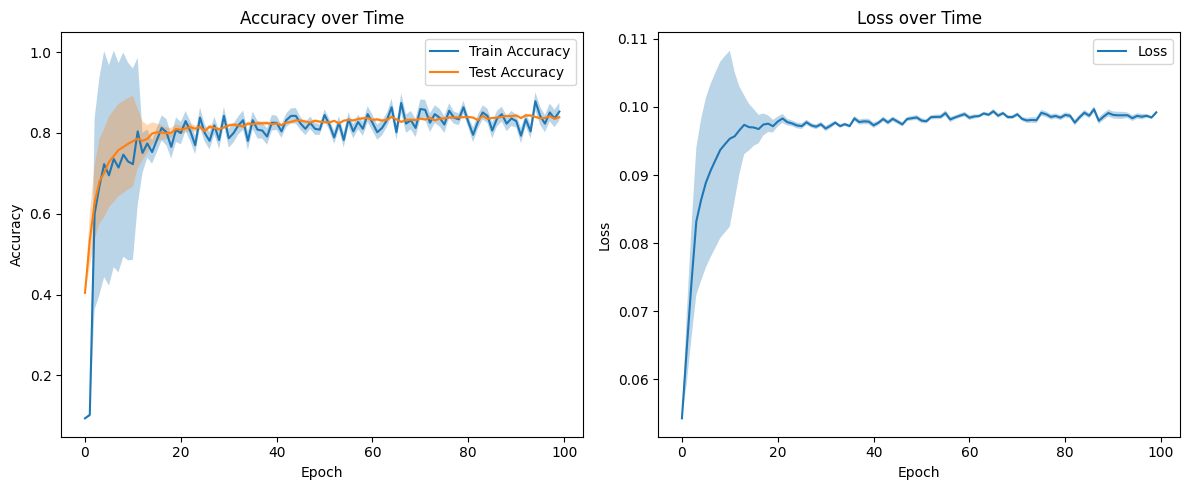

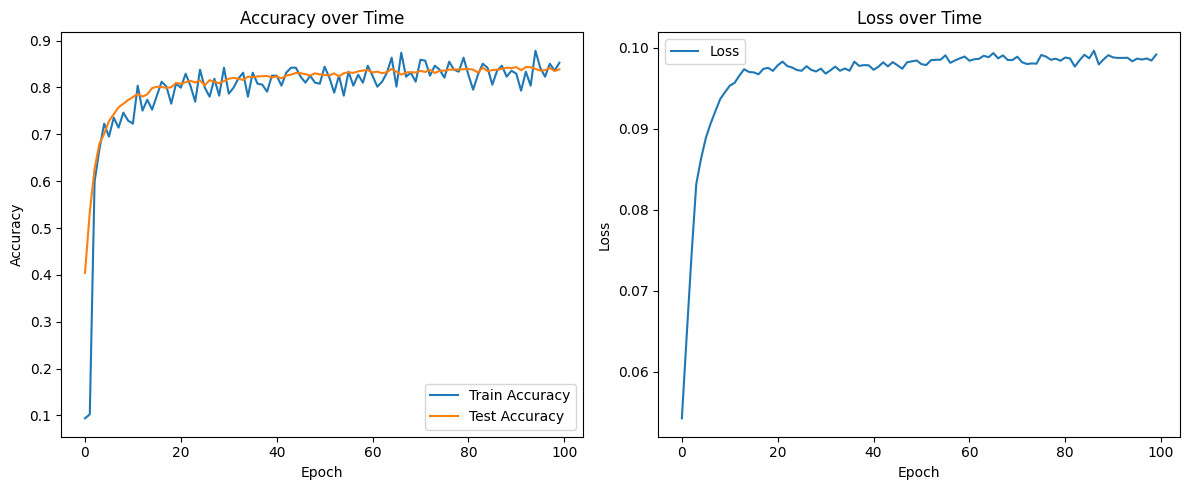

Final Train Accuracy: 0.85 ± 0.02
Final Test Accuracy: 0.84 ± 0.00


In [ ]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 32,
    "grid": 3,
    "method": "MLP",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 2, # 4, 8
    "num_conv_layers": 1, # 2, 3
    "first_channel": 1, # (1,8,8) or (3,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "distribution": "beta", # "bernoulli", "gumbel_softmax", "gaussian", "beta", "dirichlet", "multinomial", "cauchy", "laplace", "uniform"
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

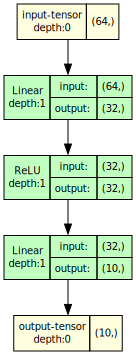

In [ ]:
## MLP architecture
import torchvision
from torchview import draw_graph

model_graph = draw_graph(q_network, input_size=(8 * 8,), expand_nested=True)
model_graph.visual_graph

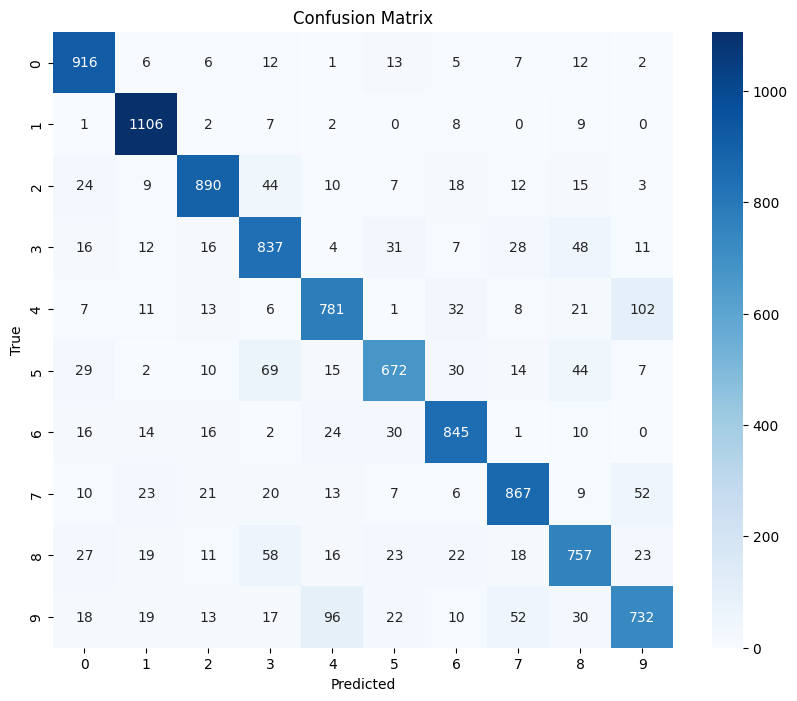

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
      # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
      # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
      # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
      # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
      # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)), # SVHN
    for images, labels in DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
                                                    #split='test', download=True, transform=transforms.Compose([
                                                 #train=False, download=True, transform=transforms.Compose([
      transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,)) # MNIST
      #transforms.Grayscale(num_output_channels=1)
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       980
           1       0.91      0.97      0.94      1135
           2       0.89      0.86      0.88      1032
           3       0.78      0.83      0.80      1010
           4       0.81      0.80      0.80       982
           5       0.83      0.75      0.79       892
           6       0.86      0.88      0.87       958
           7       0.86      0.84      0.85      1028
           8       0.79      0.78      0.78       974
           9       0.79      0.73      0.75      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



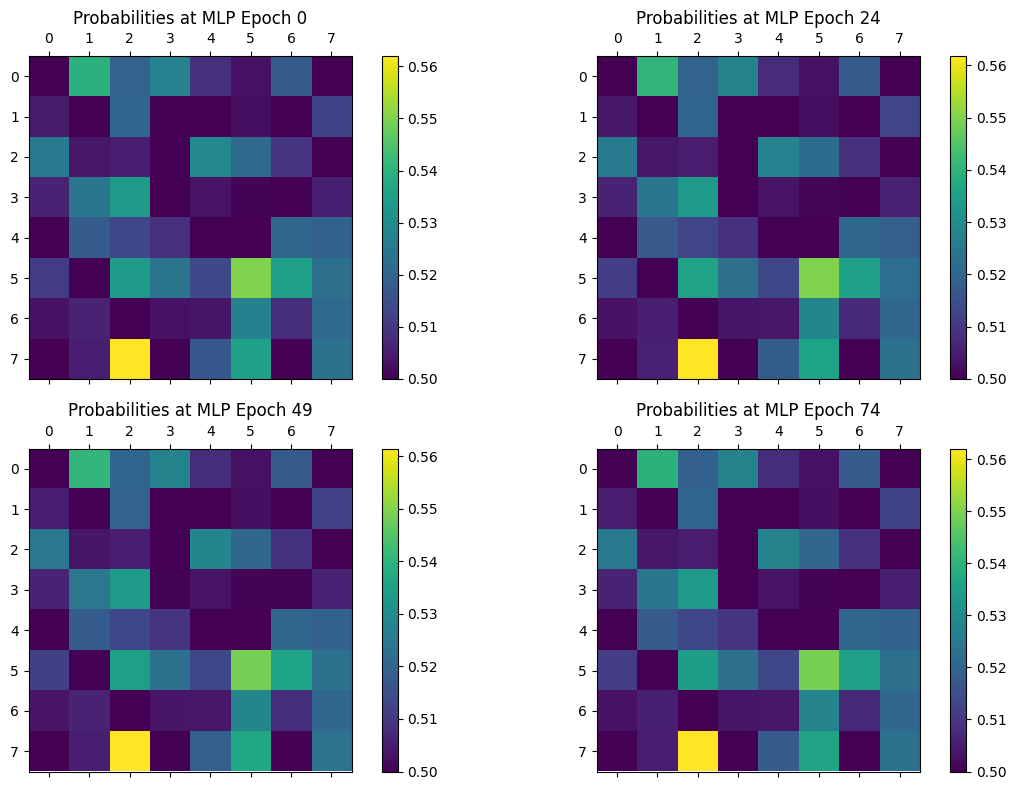

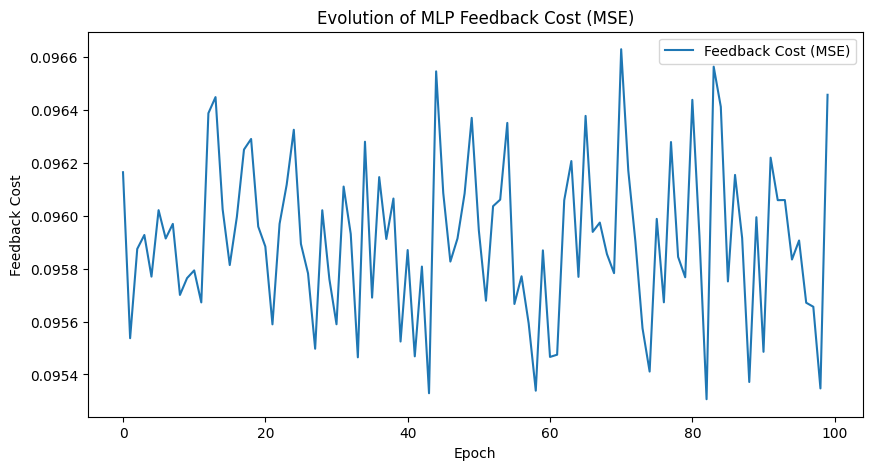

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 24, 49, 74], input_shape=(1, 8, 8)):
    # Determine the side length of the image
    side_length = int(np.sqrt(probs_history[0].shape[1]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, epoch in enumerate(epochs):
        ax = axes[i // 2, i % 2]
        if epoch < len(probs_history):
            probs = probs_history[epoch].flatten()
            if side_length ** 2 != probs.shape[0]:
                continue
            probs_image = probs.reshape((side_length, side_length))
            cax = ax.matshow(probs_image, cmap='viridis')
            fig.colorbar(cax, ax=ax)
            ax.set_title(f'Probabilities at MLP Epoch {epoch}')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Feedback Cost')
    plt.title('Evolution of MLP Feedback Cost (MSE)')
    plt.legend()
    plt.show()


plot_evolution(probs_history, feedback_cost_history)


In [ ]:
import gc
gc.collect()

41501

# KAN

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
)


KAN_SVHN_0_1730403913:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.026500501427680317
 Train accuracy:  0.09381663113006397 | 


KAN_SVHN_0_1730403913:   1%|          | 1/100 [01:47<2:56:38, 107.06s/it]

 Test accuracy:  0.3321

correct: 48 total: 469
loss: 0.017027537227232954
 Train accuracy:  0.1023454157782516 | 


KAN_SVHN_0_1730403913:   2%|▏         | 2/100 [04:12<3:31:23, 129.43s/it]

 Test accuracy:  0.5103

correct: 287 total: 469
loss: 0.022657561411799143
 Train accuracy:  0.6119402985074627 | 


KAN_SVHN_0_1730403913:   3%|▎         | 3/100 [06:58<3:56:10, 146.08s/it]

 Test accuracy:  0.6497

correct: 325 total: 469
loss: 0.025028580057023686
 Train accuracy:  0.6929637526652452 | 


KAN_SVHN_0_1730403913:   4%|▍         | 4/100 [09:43<4:05:53, 153.68s/it]

 Test accuracy:  0.7307

correct: 357 total: 469
loss: 0.02543951862894777
 Train accuracy:  0.7611940298507462 | 


KAN_SVHN_0_1730403913:   5%|▌         | 5/100 [12:29<4:10:10, 158.01s/it]

 Test accuracy:  0.772

correct: 368 total: 469
loss: 0.025311038946546217
 Train accuracy:  0.7846481876332623 | 


KAN_SVHN_0_1730403913:   6%|▌         | 6/100 [15:14<4:11:23, 160.46s/it]

 Test accuracy:  0.8044

correct: 374 total: 469
loss: 0.025472705919684757
 Train accuracy:  0.7974413646055437 | 


KAN_SVHN_0_1730403913:   7%|▋         | 7/100 [17:59<4:11:12, 162.07s/it]

 Test accuracy:  0.8345

correct: 395 total: 469
loss: 0.025272030498522686
 Train accuracy:  0.8422174840085288 | 


KAN_SVHN_0_1730403913:   8%|▊         | 8/100 [20:45<4:10:06, 163.12s/it]

 Test accuracy:  0.8443

correct: 386 total: 469
loss: 0.025502902155777794
 Train accuracy:  0.8230277185501066 | 


KAN_SVHN_0_1730403913:   9%|▉         | 9/100 [23:30<4:08:18, 163.72s/it]

 Test accuracy:  0.8545

correct: 397 total: 469
loss: 0.02553811247970885
 Train accuracy:  0.8464818763326226 | 


KAN_SVHN_0_1730403913:  10%|█         | 10/100 [26:18<4:07:37, 165.08s/it]

 Test accuracy:  0.8647

correct: 397 total: 469
loss: 0.026055637913853374
 Train accuracy:  0.8464818763326226 | 


KAN_SVHN_0_1730403913:  11%|█         | 11/100 [29:07<4:06:47, 166.38s/it]

 Test accuracy:  0.8728

correct: 399 total: 469
loss: 0.02589660992166762
 Train accuracy:  0.8507462686567164 | 


KAN_SVHN_0_1730403913:  12%|█▏        | 12/100 [31:55<4:04:54, 166.98s/it]

 Test accuracy:  0.8766

correct: 408 total: 469
loss: 0.026362774105293793
 Train accuracy:  0.8699360341151386 | 


KAN_SVHN_0_1730403913:  13%|█▎        | 13/100 [34:42<4:01:44, 166.72s/it]

 Test accuracy:  0.8824

correct: 416 total: 469
loss: 0.02581732131953814
 Train accuracy:  0.8869936034115139 | 


KAN_SVHN_0_1730403913:  14%|█▍        | 14/100 [37:27<3:58:24, 166.33s/it]

 Test accuracy:  0.8878

correct: 418 total: 469
loss: 0.025930395006323294
 Train accuracy:  0.8912579957356077 | 


KAN_SVHN_0_1730403913:  15%|█▌        | 15/100 [40:13<3:55:27, 166.20s/it]

 Test accuracy:  0.8914

correct: 438 total: 469
loss: 0.02570042003200316
 Train accuracy:  0.9339019189765458 | 


KAN_SVHN_0_1730403913:  16%|█▌        | 16/100 [43:00<3:52:53, 166.36s/it]

 Test accuracy:  0.8916

correct: 411 total: 469
loss: 0.02496566259459074
 Train accuracy:  0.8763326226012793 | 


KAN_SVHN_0_1730403913:  17%|█▋        | 17/100 [45:45<3:49:56, 166.22s/it]

 Test accuracy:  0.8942

correct: 409 total: 469
loss: 0.025700500757217026
 Train accuracy:  0.8720682302771855 | 


KAN_SVHN_0_1730403913:  18%|█▊        | 18/100 [48:31<3:46:57, 166.07s/it]

 Test accuracy:  0.8937

correct: 420 total: 469
loss: 0.025300493787553138
 Train accuracy:  0.8955223880597015 | 


KAN_SVHN_0_1730403913:  19%|█▉        | 19/100 [51:17<3:44:02, 165.96s/it]

 Test accuracy:  0.8963

correct: 410 total: 469
loss: 0.025415112701322098
 Train accuracy:  0.8742004264392325 | 


KAN_SVHN_0_1730403913:  20%|██        | 20/100 [54:03<3:41:15, 165.95s/it]

 Test accuracy:  0.896

correct: 417 total: 469
loss: 0.02576421417677199
 Train accuracy:  0.8891257995735607 | 


KAN_SVHN_0_1730403913:  21%|██        | 21/100 [56:49<3:38:30, 165.95s/it]

 Test accuracy:  0.9

correct: 428 total: 469
loss: 0.025555892662802483
 Train accuracy:  0.9125799573560768 | 


KAN_SVHN_0_1730403913:  22%|██▏       | 22/100 [59:35<3:35:43, 165.94s/it]

 Test accuracy:  0.9022

correct: 423 total: 469
loss: 0.025664989784884174
 Train accuracy:  0.9019189765458422 | 


KAN_SVHN_0_1730403913:  23%|██▎       | 23/100 [1:02:21<3:33:05, 166.05s/it]

 Test accuracy:  0.9028

correct: 420 total: 469
loss: 0.025992524434826268
 Train accuracy:  0.8955223880597015 | 


KAN_SVHN_0_1730403913:  24%|██▍       | 24/100 [1:05:06<3:30:02, 165.82s/it]

 Test accuracy:  0.9007

correct: 430 total: 469
loss: 0.02508825869527834
 Train accuracy:  0.9168443496801706 | 


KAN_SVHN_0_1730403913:  25%|██▌       | 25/100 [1:07:51<3:26:55, 165.54s/it]

 Test accuracy:  0.905

correct: 415 total: 469
loss: 0.02569496081367548
 Train accuracy:  0.8848614072494669 | 


KAN_SVHN_0_1730403913:  26%|██▌       | 26/100 [1:11:05<3:34:49, 174.18s/it]

 Test accuracy:  0.9057

correct: 415 total: 469
loss: 0.02723481925105108
 Train accuracy:  0.8848614072494669 | 


KAN_SVHN_0_1730403913:  27%|██▋       | 27/100 [1:13:51<3:28:47, 171.61s/it]

 Test accuracy:  0.9038

correct: 424 total: 469
loss: 0.027631235767656297
 Train accuracy:  0.9040511727078892 | 


KAN_SVHN_0_1730403913:  28%|██▊       | 28/100 [1:16:36<3:23:36, 169.68s/it]

 Test accuracy:  0.9063

correct: 414 total: 469
loss: 0.027356737106641344
 Train accuracy:  0.8827292110874201 | 


KAN_SVHN_0_1730403913:  29%|██▉       | 29/100 [1:19:22<3:19:15, 168.39s/it]

 Test accuracy:  0.9095

correct: 421 total: 469
loss: 0.0278933002277891
 Train accuracy:  0.8976545842217484 | 


KAN_SVHN_0_1730403913:  30%|███       | 30/100 [1:22:08<3:15:42, 167.75s/it]

 Test accuracy:  0.909

correct: 435 total: 469
loss: 0.02737477293877459
 Train accuracy:  0.9275053304904051 | 


KAN_SVHN_0_1730403913:  31%|███       | 31/100 [1:24:53<3:12:02, 166.99s/it]

 Test accuracy:  0.9097

correct: 418 total: 469
loss: 0.027383996443803123
 Train accuracy:  0.8912579957356077 | 


KAN_SVHN_0_1730403913:  32%|███▏      | 32/100 [1:27:39<3:08:56, 166.72s/it]

 Test accuracy:  0.9102

correct: 438 total: 469
loss: 0.027672665725861276
 Train accuracy:  0.9339019189765458 | 


KAN_SVHN_0_1730403913:  33%|███▎      | 33/100 [1:30:25<3:05:54, 166.49s/it]

 Test accuracy:  0.9054

correct: 430 total: 469
loss: 0.027651748449198092
 Train accuracy:  0.9168443496801706 | 


KAN_SVHN_0_1730403913:  34%|███▍      | 34/100 [1:33:11<3:03:02, 166.40s/it]

 Test accuracy:  0.9104

correct: 421 total: 469
loss: 0.02764325519837042
 Train accuracy:  0.8976545842217484 | 


KAN_SVHN_0_1730403913:  35%|███▌      | 35/100 [1:35:57<2:59:53, 166.05s/it]

 Test accuracy:  0.9074

correct: 429 total: 469
loss: 0.027558612053407663
 Train accuracy:  0.9147121535181236 | 


KAN_SVHN_0_1730403913:  36%|███▌      | 36/100 [1:38:42<2:57:04, 166.00s/it]

 Test accuracy:  0.9112

correct: 417 total: 469
loss: 0.027920439696388202
 Train accuracy:  0.8891257995735607 | 


KAN_SVHN_0_1730403913:  37%|███▋      | 37/100 [1:41:28<2:54:08, 165.85s/it]

 Test accuracy:  0.911

correct: 436 total: 469
loss: 0.027730883279843115
 Train accuracy:  0.929637526652452 | 


KAN_SVHN_0_1730403913:  38%|███▊      | 38/100 [1:44:13<2:51:15, 165.74s/it]

 Test accuracy:  0.9118

correct: 422 total: 469
loss: 0.027915622903975344
 Train accuracy:  0.8997867803837953 | 


KAN_SVHN_0_1730403913:  39%|███▉      | 39/100 [1:46:59<2:48:23, 165.63s/it]

 Test accuracy:  0.9122

correct: 429 total: 469
loss: 0.027969690055640012
 Train accuracy:  0.9147121535181236 | 


KAN_SVHN_0_1730403913:  40%|████      | 40/100 [1:49:45<2:45:43, 165.73s/it]

 Test accuracy:  0.9097

correct: 425 total: 469
loss: 0.027366099271502322
 Train accuracy:  0.906183368869936 | 


KAN_SVHN_0_1730403913:  41%|████      | 41/100 [1:52:31<2:43:06, 165.88s/it]

 Test accuracy:  0.9126

correct: 427 total: 469
loss: 0.02726074948168195
 Train accuracy:  0.9104477611940298 | 


KAN_SVHN_0_1730403913:  42%|████▏     | 42/100 [1:55:17<2:40:18, 165.84s/it]

 Test accuracy:  0.9147

correct: 430 total: 469
loss: 0.027548359484592482
 Train accuracy:  0.9168443496801706 | 


KAN_SVHN_0_1730403913:  43%|████▎     | 43/100 [1:58:02<2:37:21, 165.64s/it]

 Test accuracy:  0.9087

correct: 435 total: 469
loss: 0.02780611164518384
 Train accuracy:  0.9275053304904051 | 


KAN_SVHN_0_1730403913:  44%|████▍     | 44/100 [2:00:47<2:34:28, 165.51s/it]

 Test accuracy:  0.9139

correct: 428 total: 469
loss: 0.02775109024531742
 Train accuracy:  0.9125799573560768 | 


KAN_SVHN_0_1730403913:  45%|████▌     | 45/100 [2:03:33<2:31:46, 165.58s/it]

 Test accuracy:  0.9105

correct: 423 total: 469
loss: 0.02755914008947832
 Train accuracy:  0.9019189765458422 | 


KAN_SVHN_0_1730403913:  46%|████▌     | 46/100 [2:06:18<2:28:59, 165.55s/it]

 Test accuracy:  0.9144

correct: 426 total: 469
loss: 0.027130158018392286
 Train accuracy:  0.908315565031983 | 


KAN_SVHN_0_1730403913:  47%|████▋     | 47/100 [2:09:04<2:26:09, 165.47s/it]

 Test accuracy:  0.911

correct: 426 total: 469
loss: 0.02741491918696333
 Train accuracy:  0.908315565031983 | 


KAN_SVHN_0_1730403913:  48%|████▊     | 48/100 [2:11:49<2:23:22, 165.43s/it]

 Test accuracy:  0.9149

correct: 429 total: 469
loss: 0.02769519179574907
 Train accuracy:  0.9147121535181236 | 


KAN_SVHN_0_1730403913:  49%|████▉     | 49/100 [2:14:34<2:20:35, 165.40s/it]

 Test accuracy:  0.9162

correct: 423 total: 469
loss: 0.02750229146847847
 Train accuracy:  0.9019189765458422 | 


KAN_SVHN_0_1730403913:  50%|█████     | 50/100 [2:17:20<2:17:52, 165.44s/it]

 Test accuracy:  0.9141

correct: 437 total: 469
loss: 0.027605555407496405
 Train accuracy:  0.9317697228144989 | 


KAN_SVHN_0_1730403913:  51%|█████     | 51/100 [2:20:05<2:15:06, 165.45s/it]

 Test accuracy:  0.915

correct: 429 total: 469
loss: 0.027442649219320145
 Train accuracy:  0.9147121535181236 | 


KAN_SVHN_0_1730403913:  52%|█████▏    | 52/100 [2:22:51<2:12:24, 165.52s/it]

 Test accuracy:  0.9153

correct: 428 total: 469
loss: 0.027725749412801728
 Train accuracy:  0.9125799573560768 | 


KAN_SVHN_0_1730403913:  53%|█████▎    | 53/100 [2:25:37<2:09:39, 165.52s/it]

 Test accuracy:  0.9179

correct: 428 total: 469
loss: 0.027863586333387695
 Train accuracy:  0.9125799573560768 | 


KAN_SVHN_0_1730403913:  54%|█████▍    | 54/100 [2:28:21<2:06:45, 165.34s/it]

 Test accuracy:  0.9186

correct: 428 total: 469
loss: 0.02774110237664696
 Train accuracy:  0.9125799573560768 | 


KAN_SVHN_0_1730403913:  55%|█████▌    | 55/100 [2:31:07<2:04:00, 165.35s/it]

 Test accuracy:  0.916

correct: 432 total: 469
loss: 0.028058468215246952
 Train accuracy:  0.9211087420042644 | 


KAN_SVHN_0_1730403913:  56%|█████▌    | 56/100 [2:33:52<2:01:17, 165.40s/it]

 Test accuracy:  0.919

correct: 414 total: 469
loss: 0.027683457786610514
 Train accuracy:  0.8827292110874201 | 


KAN_SVHN_0_1730403913:  57%|█████▋    | 57/100 [2:36:38<1:58:32, 165.41s/it]

 Test accuracy:  0.9157

correct: 432 total: 469
loss: 0.027920235583840658
 Train accuracy:  0.9211087420042644 | 


KAN_SVHN_0_1730403913:  58%|█████▊    | 58/100 [2:39:23<1:55:48, 165.44s/it]

 Test accuracy:  0.9163

correct: 419 total: 469
loss: 0.02750940646912688
 Train accuracy:  0.8933901918976546 | 


KAN_SVHN_0_1730403913:  59%|█████▉    | 59/100 [2:42:08<1:52:59, 165.35s/it]

 Test accuracy:  0.915

correct: 420 total: 469
loss: 0.027961407946958852
 Train accuracy:  0.8955223880597015 | 


KAN_SVHN_0_1730403913:  60%|██████    | 60/100 [2:44:54<1:50:16, 165.40s/it]

 Test accuracy:  0.919

correct: 431 total: 469
loss: 0.027406923832304315
 Train accuracy:  0.9189765458422174 | 


KAN_SVHN_0_1730403913:  61%|██████    | 61/100 [2:47:39<1:47:23, 165.21s/it]

 Test accuracy:  0.9184

correct: 419 total: 469
loss: 0.027531967917357934
 Train accuracy:  0.8933901918976546 | 


KAN_SVHN_0_1730403913:  62%|██████▏   | 62/100 [2:50:25<1:44:51, 165.56s/it]

 Test accuracy:  0.9173

correct: 432 total: 469
loss: 0.02787350086388049
 Train accuracy:  0.9211087420042644 | 


KAN_SVHN_0_1730403913:  63%|██████▎   | 63/100 [2:53:11<1:42:06, 165.58s/it]

 Test accuracy:  0.9165

correct: 432 total: 469
loss: 0.02788356063502239
 Train accuracy:  0.9211087420042644 | 


KAN_SVHN_0_1730403913:  64%|██████▍   | 64/100 [2:55:56<1:39:22, 165.64s/it]

 Test accuracy:  0.9203

correct: 421 total: 469
loss: 0.027967976219554953
 Train accuracy:  0.8976545842217484 | 


KAN_SVHN_0_1730403913:  65%|██████▌   | 65/100 [2:58:42<1:36:32, 165.49s/it]

 Test accuracy:  0.9182

correct: 425 total: 469
loss: 0.02767846015677142
 Train accuracy:  0.906183368869936 | 


KAN_SVHN_0_1730403913:  66%|██████▌   | 66/100 [3:01:27<1:33:43, 165.38s/it]

 Test accuracy:  0.9197

correct: 438 total: 469
loss: 0.0280153865614203
 Train accuracy:  0.9339019189765458 | 


KAN_SVHN_0_1730403913:  67%|██████▋   | 67/100 [3:04:13<1:31:01, 165.50s/it]

 Test accuracy:  0.918

correct: 416 total: 469
loss: 0.02727963893549211
 Train accuracy:  0.8869936034115139 | 


KAN_SVHN_0_1730403913:  68%|██████▊   | 68/100 [3:06:57<1:28:10, 165.33s/it]

 Test accuracy:  0.9209

correct: 425 total: 469
loss: 0.02761032529421516
 Train accuracy:  0.906183368869936 | 


KAN_SVHN_0_1730403913:  69%|██████▉   | 69/100 [3:09:43<1:25:22, 165.25s/it]

 Test accuracy:  0.9195

correct: 440 total: 469
loss: 0.028007585571201116
 Train accuracy:  0.9381663113006397 | 


KAN_SVHN_0_1730403913:  70%|███████   | 70/100 [3:12:28<1:22:42, 165.42s/it]

 Test accuracy:  0.9194

correct: 426 total: 469
loss: 0.02770447767556095
 Train accuracy:  0.908315565031983 | 


KAN_SVHN_0_1730403913:  71%|███████   | 71/100 [3:15:14<1:20:02, 165.59s/it]

 Test accuracy:  0.9197

correct: 444 total: 469
loss: 0.02762999939821613
 Train accuracy:  0.9466950959488273 | 


KAN_SVHN_0_1730403913:  72%|███████▏  | 72/100 [3:18:00<1:17:17, 165.61s/it]

 Test accuracy:  0.9203

correct: 433 total: 469
loss: 0.027418267835717974
 Train accuracy:  0.9232409381663113 | 


KAN_SVHN_0_1730403913:  73%|███████▎  | 73/100 [3:20:46<1:14:33, 165.69s/it]

 Test accuracy:  0.9201

correct: 429 total: 469
loss: 0.02731807885973502
 Train accuracy:  0.9147121535181236 | 


KAN_SVHN_0_1730403913:  74%|███████▍  | 74/100 [3:23:32<1:11:49, 165.76s/it]

 Test accuracy:  0.9196

correct: 440 total: 469
loss: 0.027761802059421536
 Train accuracy:  0.9381663113006397 | 


KAN_SVHN_0_1730403913:  75%|███████▌  | 75/100 [3:26:17<1:09:02, 165.72s/it]

 Test accuracy:  0.9183

correct: 434 total: 469
loss: 0.02791534814594397
 Train accuracy:  0.9253731343283582 | 


KAN_SVHN_0_1730403913:  76%|███████▌  | 76/100 [3:29:03<1:06:13, 165.56s/it]

 Test accuracy:  0.9205

correct: 422 total: 469
loss: 0.027311161801870317
 Train accuracy:  0.8997867803837953 | 


KAN_SVHN_0_1730403913:  77%|███████▋  | 77/100 [3:31:49<1:03:30, 165.68s/it]

 Test accuracy:  0.9198

correct: 429 total: 469
loss: 0.02730623180709922
 Train accuracy:  0.9147121535181236 | 


KAN_SVHN_0_1730403913:  78%|███████▊  | 78/100 [3:34:34<1:00:42, 165.58s/it]

 Test accuracy:  0.9212

correct: 437 total: 469
loss: 0.027215420848318635
 Train accuracy:  0.9317697228144989 | 


KAN_SVHN_0_1730403913:  79%|███████▉  | 79/100 [3:37:19<57:57, 165.59s/it]  

 Test accuracy:  0.9183

correct: 432 total: 469
loss: 0.027314264106868047
 Train accuracy:  0.9211087420042644 | 


KAN_SVHN_0_1730403913:  80%|████████  | 80/100 [3:40:05<55:12, 165.60s/it]

 Test accuracy:  0.9241

correct: 432 total: 469
loss: 0.027509398041551173
 Train accuracy:  0.9211087420042644 | 


KAN_SVHN_0_1730403913:  81%|████████  | 81/100 [3:42:51<52:28, 165.73s/it]

 Test accuracy:  0.9193

correct: 430 total: 469
loss: 0.02725577404273789
 Train accuracy:  0.9168443496801706 | 


KAN_SVHN_0_1730403913:  82%|████████▏ | 82/100 [3:45:38<49:49, 166.09s/it]

 Test accuracy:  0.9182

correct: 426 total: 469
loss: 0.026893177818356036
 Train accuracy:  0.908315565031983 | 


KAN_SVHN_0_1730403913:  83%|████████▎ | 83/100 [3:48:24<47:01, 165.97s/it]

 Test accuracy:  0.9233

correct: 444 total: 469
loss: 0.027241624687224436
 Train accuracy:  0.9466950959488273 | 


KAN_SVHN_0_1730403913:  84%|████████▍ | 84/100 [3:51:10<44:15, 165.94s/it]

 Test accuracy:  0.9227

correct: 432 total: 469
loss: 0.027480904406099432
 Train accuracy:  0.9211087420042644 | 


KAN_SVHN_0_1730403913:  85%|████████▌ | 85/100 [3:53:56<41:31, 166.12s/it]

 Test accuracy:  0.9235

correct: 434 total: 469
loss: 0.027589092066864978
 Train accuracy:  0.9253731343283582 | 


KAN_SVHN_0_1730403913:  86%|████████▌ | 86/100 [3:56:42<38:46, 166.18s/it]

 Test accuracy:  0.9223

correct: 438 total: 469
loss: 0.027626958987447246
 Train accuracy:  0.9339019189765458 | 


KAN_SVHN_0_1730403913:  87%|████████▋ | 87/100 [3:59:28<35:56, 165.90s/it]

 Test accuracy:  0.9217

correct: 432 total: 469
loss: 0.02678845423474304
 Train accuracy:  0.9211087420042644 | 


KAN_SVHN_0_1730403913:  88%|████████▊ | 88/100 [4:02:13<33:09, 165.81s/it]

 Test accuracy:  0.9238

correct: 426 total: 469
loss: 0.026924870932089496
 Train accuracy:  0.908315565031983 | 


KAN_SVHN_0_1730403913:  89%|████████▉ | 89/100 [4:04:59<30:24, 165.83s/it]

 Test accuracy:  0.9224

correct: 427 total: 469
loss: 0.02729051867162368
 Train accuracy:  0.9104477611940298 | 


KAN_SVHN_0_1730403913:  90%|█████████ | 90/100 [4:07:45<27:39, 165.94s/it]

 Test accuracy:  0.9244

correct: 441 total: 469
loss: 0.027417258329705388
 Train accuracy:  0.9402985074626866 | 


KAN_SVHN_0_1730403913:  91%|█████████ | 91/100 [4:10:31<24:52, 165.88s/it]

 Test accuracy:  0.9205

correct: 433 total: 469
loss: 0.026932045275262044
 Train accuracy:  0.9232409381663113 | 


KAN_SVHN_0_1730403913:  92%|█████████▏| 92/100 [4:13:17<22:08, 166.01s/it]

 Test accuracy:  0.9212

correct: 429 total: 469
loss: 0.02757767008653264
 Train accuracy:  0.9147121535181236 | 


KAN_SVHN_0_1730403913:  93%|█████████▎| 93/100 [4:16:04<19:23, 166.27s/it]

 Test accuracy:  0.9231

correct: 435 total: 469
loss: 0.027053866980235968
 Train accuracy:  0.9275053304904051 | 


KAN_SVHN_0_1730403913:  94%|█████████▍| 94/100 [4:18:50<16:36, 166.10s/it]

 Test accuracy:  0.9247

correct: 429 total: 469
loss: 0.02708982291228291
 Train accuracy:  0.9147121535181236 | 


KAN_SVHN_0_1730403913:  95%|█████████▌| 95/100 [4:21:36<13:50, 166.17s/it]

 Test accuracy:  0.9237

correct: 436 total: 469
loss: 0.027717893089312735
 Train accuracy:  0.929637526652452 | 


KAN_SVHN_0_1730403913:  96%|█████████▌| 96/100 [4:24:23<11:04, 166.17s/it]

 Test accuracy:  0.9226

correct: 436 total: 469
loss: 0.02727266699909719
 Train accuracy:  0.929637526652452 | 


KAN_SVHN_0_1730403913:  97%|█████████▋| 97/100 [4:27:08<08:18, 166.09s/it]

 Test accuracy:  0.9217

correct: 420 total: 469
loss: 0.026841538924493515
 Train accuracy:  0.8955223880597015 | 


KAN_SVHN_0_1730403913:  98%|█████████▊| 98/100 [4:29:54<05:31, 165.95s/it]

 Test accuracy:  0.9226

correct: 439 total: 469
loss: 0.02643766846738136
 Train accuracy:  0.9360341151385928 | 


KAN_SVHN_0_1730403913:  99%|█████████▉| 99/100 [4:32:40<02:45, 165.90s/it]

 Test accuracy:  0.9244

correct: 434 total: 469
loss: 0.02728341277569596
 Train accuracy:  0.9253731343283582 | 


KAN_SVHN_0_1730403913: 100%|██████████| 100/100 [4:35:26<00:00, 165.26s/it]

 Test accuracy:  0.925


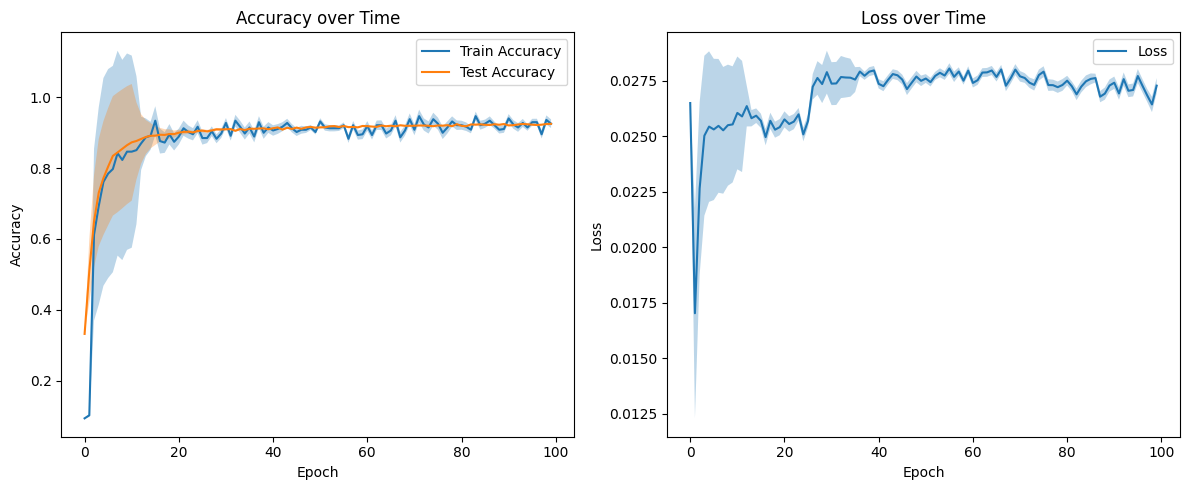

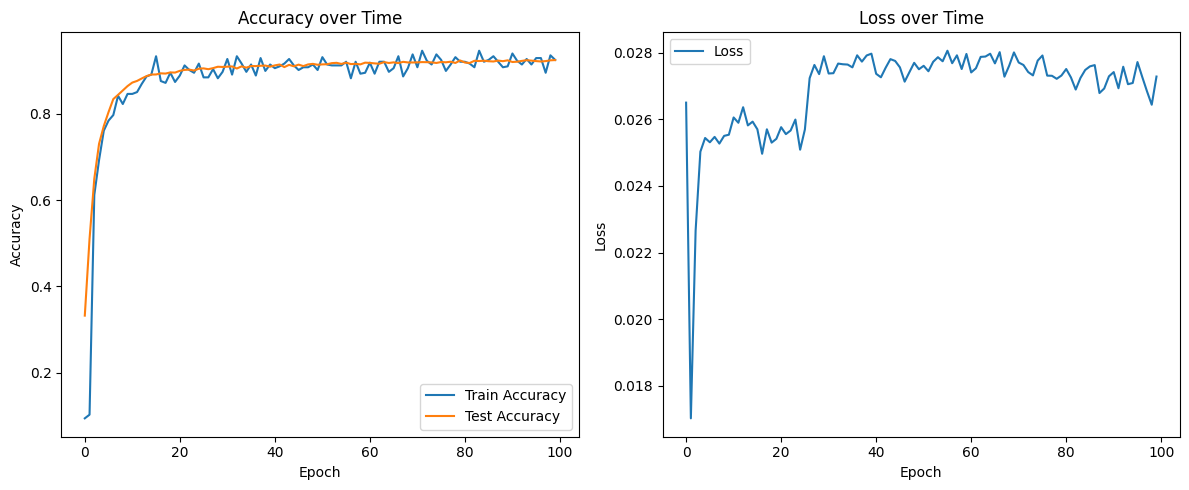

Final Train Accuracy: 0.93 ± 0.01
Final Test Accuracy: 0.93 ± 0.00


In [ ]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 8,
    "grid": 3,
    "method": "KAN",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 2,
    "num_conv_layers": 1,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

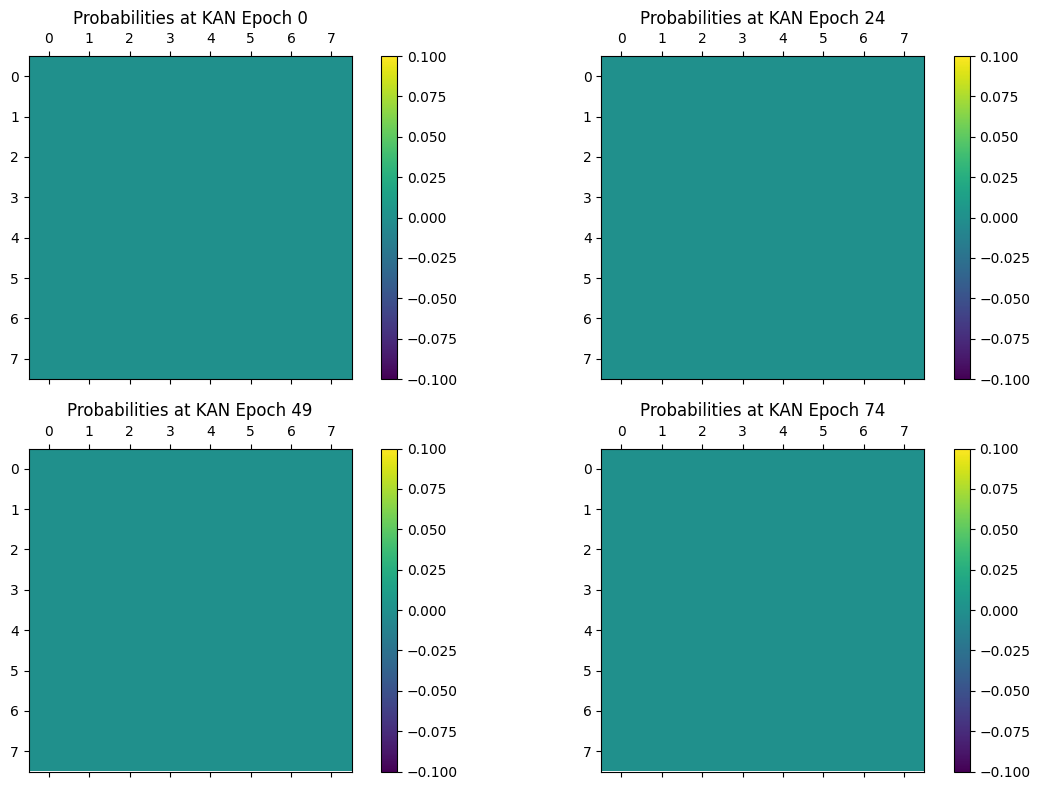

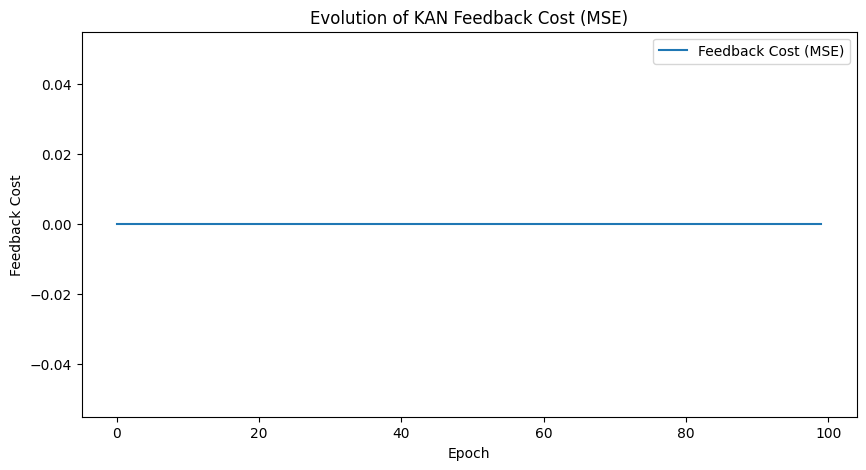

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 24, 49, 74], input_shape=(1, 8, 8)):
    # Determine the side length of the image
    side_length = int(np.sqrt(probs_history[0].shape[1]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, epoch in enumerate(epochs):
        ax = axes[i // 2, i % 2]
        if epoch < len(probs_history):
            probs = probs_history[epoch].flatten()
            if side_length ** 2 != probs.shape[0]:
                continue
            probs_image = probs.reshape((side_length, side_length))
            cax = ax.matshow(probs_image, cmap='viridis')
            fig.colorbar(cax, ax=ax)
            ax.set_title(f'Probabilities at KAN Epoch {epoch}')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Feedback Cost')
    plt.title('Evolution of KAN Feedback Cost (MSE)')
    plt.legend()
    plt.show()


plot_evolution(probs_history, feedback_cost_history)


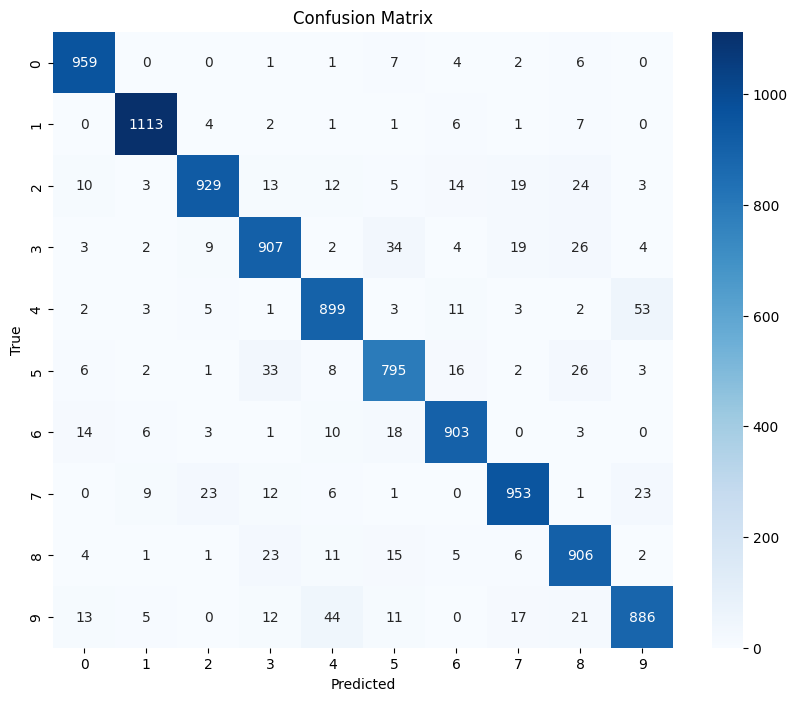

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
      # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
      # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
      # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
      # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
      # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)), # SVHN
    for images, labels in DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
                                                    #split='test', download=True, transform=transforms.Compose([
                                                 #train=False, download=True, transform=transforms.Compose([
      transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,)) # MNIST
      #transforms.Grayscale(num_output_channels=1)
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.95      0.90      0.93      1032
           3       0.90      0.90      0.90      1010
           4       0.90      0.92      0.91       982
           5       0.89      0.89      0.89       892
           6       0.94      0.94      0.94       958
           7       0.93      0.93      0.93      1028
           8       0.89      0.93      0.91       974
           9       0.91      0.88      0.89      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.92     10000



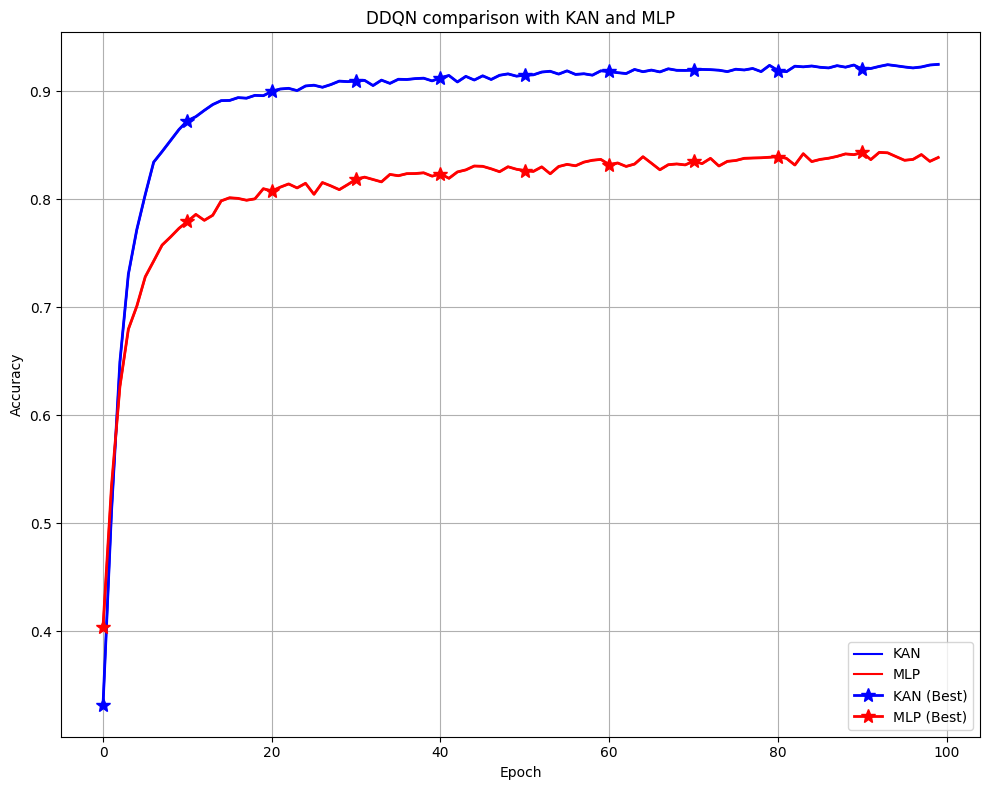

In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import glob


algo1, algo2 = 'KAN', 'MLP'

files_algo1 = glob.glob(f"/kaggle/working/results/{algo1}_*.csv")
files_algo2 = glob.glob(f"/kaggle/working/results/{algo2}_*.csv")

df_algo1 = pd.concat((pd.read_csv(file) for file in files_algo1))
df_algo2 = pd.concat((pd.read_csv(file) for file in files_algo2))

median_algo1 = df_algo1.groupby('epoch')['accuracy'].median()
median_algo2 = df_algo2.groupby('epoch')['accuracy'].median()
quantile_25_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.25)
quantile_75_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.75)
quantile_25_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.25)
quantile_75_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.75)

best_algo1 = df_algo1.groupby('epoch')['accuracy'].max()
best_algo2 = df_algo2.groupby('epoch')['accuracy'].max()

plt.figure(figsize=(10, 8))

plt.plot(median_algo1.index, median_algo1, label=f"{algo1}", color='blue')
plt.fill_between(median_algo1.index, quantile_25_algo1, quantile_75_algo1, alpha=0.3, color='blue')

plt.plot(median_algo2.index, median_algo2, label=f"{algo2}", color='red')
plt.fill_between(median_algo2.index, quantile_25_algo2, quantile_75_algo2, alpha=0.3, color='red')

plt.plot(best_algo1.index, best_algo1, label=f"{algo1} (Best)", color='blue', marker='*', markersize=10, markevery=10, lw=2)

plt.plot(best_algo2.index, best_algo2, label=f"{algo2} (Best)", color='red', marker='*', markersize=10, markevery=10, lw=2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'DDQN comparison with {algo1} and {algo2}')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
import gc
gc.collect()

16879

In [ ]:
# q_network.prune()

In [ ]:
# q_network.plot(beta=30, scale=1, out_vars=[0,1,2,3,4,5,6,7,8,9])

In [ ]:
# lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
# q_network.auto_symbolic(lib=lib)

In [ ]:
# symbolic_formula = f"### The symbolic formula of the policy is:"
# formulas = q_network.symbolic_formula()[0]

In [ ]:
# from sympy import latex
# import glob
# import os

# import gymnasium as gym
# import numpy as np
# from gymnasium.wrappers import RecordVideo
# from moviepy.video.compositing.concatenate import concatenate_videoclips
# from moviepy.video.io.VideoFileClip import VideoFileClip
# from sympy import latex
# import matplotlib.pyplot as plt


# for i, formula in enumerate(formulas):
#     symbolic_formula += "\n$$ a_" + str(i) + "=" + latex(formula) + "$$"
# symbolic_formula += "\n" + r"$$ a = \underset{i}{\mathrm{argmax}} \ a_i.$$"

In [ ]:
# print(symbolic_formula)

In [ ]:
# formulas[0] # formula of a_0

In [ ]:
# print(formulas[0])

In [ ]:
# formulas

In [ ]:
# import re
# from collections import Counter
# import matplotlib.pyplot as plt

# # Given symbolic formula (abbreviated for clarity)
# formula = str(formulas)

# # Extract all feature occurrences
# features = re.findall(r'x_\d+', formula)

# # Count feature occurrences
# feature_counts = Counter(features)

# # Extract coefficients for the features
# coefficients = re.findall(r'([+-]?\d*\.?\d+)\*?x_\d+', formula)
# coefficients = [float(c) for c in coefficients]

# # Combine frequency and coefficient magnitude for importance
# feature_importance = {}
# for feature in feature_counts:
#     feature_importance[feature] = feature_counts[feature]

# # Sort features by importance
# sorted_features = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

# # Plotting feature importance
# features, importance = zip(*sorted_features)
# plt.figure(figsize=(12, 8))
# plt.bar(features, importance)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Feature Importance')
# plt.xticks(rotation=90)
# plt.show()


In [ ]:
# import re
# from collections import Counter
# import matplotlib.pyplot as plt

# def parse_formula(formula):
#     # Extract all feature occurrences
#     features = re.findall(r'x_\d+', formula)
#     # Extract coefficients for the features
#     coefficients = re.findall(r'([+-]?\d*\.?\d+)\*?x_\d+', formula)
#     coefficients = [float(c) for c in coefficients]
#     return features, coefficients

# def compute_feature_importance(features, coefficients):
#     # Count feature occurrences
#     feature_counts = Counter(features)
#     # Combine frequency and coefficient magnitude for importance
#     feature_importance = {}
#     for feature in feature_counts:
#         feature_importance[feature] = feature_counts[feature]
#     return feature_importance

# # Plot feature importance for each component
# fig, axes = plt.subplots(5, 2, figsize=(15, 25))
# axes = axes.flatten()

# for i, formula in enumerate(formulas):
#     features, coefficients = parse_formula(str(formula))
#     feature_importance = compute_feature_importance(features, coefficients)

#     # Sort features by importance
#     sorted_features = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

#     # Plotting feature importance
#     features, importance = zip(*sorted_features)
#     axes[i].bar(features, importance)
#     axes[i].set_xlabel('Features')
#     axes[i].set_ylabel('Importance')
#     axes[i].set_title(f'Feature Importance for a_{i}')
#     axes[i].tick_params(axis='x', rotation=90)

# plt.tight_layout()
# plt.show()


First Part: Activation Functions for the Middle Neurons in the First Hidden Layer

Objective: Plot activation functions for the middle neurons in the first hidden layer.
Setup: A 2x6 grid (2 rows, 6 columns) for plotting.
Loop: Iterate over input neurons (i = 0 and i = 1) and middle neurons (j = 0 to 5).
Layer: l = 1 corresponds to the first hidden layer.
Extraction: Extract spline_preacts and spline_postacts for the specified neurons.
Sorting: Sort inputs and corresponding outputs for better visualization.
Plotting: Plot the activation function for each combination in the grid.

In [ ]:
# # Create a 2x6 grid for plotting (2 rows, 6 columns)
# fig, axs = plt.subplots(8, 2, figsize=(10, 35))
# middle_neurons = [0, 1, 2, 3, 4, 5, 6, 7]  # Output neurons in the first hidden layer
# input_neurons = [0, 1]

# model = q_network

# for row, i in enumerate(middle_neurons):  # Input neurons i = 0 and i = 1
#     for col, j in enumerate(input_neurons):
#         l = 1  # Layer index (first hidden layer)

#         # Extract inputs and outputs of the spline activation functions
#         inputs = model.spline_preacts[l][:, i, j]
#         outputs = model.spline_postacts[l][:, i, j]

#         # Sort the inputs and corresponding outputs for plotting
#         rank = np.argsort(inputs)
#         inputs = inputs[rank]
#         outputs = outputs[rank]

#         # Determine subplot location
#         ax = axs[row, col]

#         # Plot the activation function
#         ax.plot(inputs, outputs, marker="o")
#         ax.set_title(f'Activation Function\nLayer {l}, Input Neuron {i}, Output Neuron {j}')
#         ax.set_xlabel('Input')
#         ax.set_ylabel('Output')
#         ax.grid(True)

# plt.tight_layout(pad=3)
# plt.show()


Second Part: Activation Functions Between the First Hidden Layer and the Output Layer

Objective: Plot activation functions for the neurons between the first hidden layer and the output layer.
Setup: A 6x2 grid (6 rows, 2 columns) for plotting.
Loop: Iterate over hidden neurons (i = 0 to 5) and output neurons (j = 0 and j = 1).
Layer: l = 1 corresponds to the output layer.
Extraction: Extract spline_preacts and spline_postacts for the specified neurons.
Sorting: Sort inputs and corresponding outputs for better visualization.
Plotting: Plot the activation function for each combination in the grid.

In [ ]:
# # Extract and plot activation functions for the neurons between the first hidden layer and the output layer
# hidden_neurons = [0, 1, 2, 3, 4, 5, 6, 7]  # Neurons in the first hidden layer
# output_neurons = [0, 1]  # Neurons in the output layer

# # Create a 3x2 grid for plotting
# fig, axs = plt.subplots(8, 2, figsize=(10, 35))

# for row, i in enumerate(hidden_neurons):  # Neurons in the first hidden layer
#     for col, j in enumerate(output_neurons):  # Neurons in the output layer
#         l = 1  # Layer index (output layer)

#         # Extract inputs and outputs of the spline activation functions
#         inputs = model.spline_preacts[l][:, j, i]
#         outputs = model.spline_postacts[l][:, j, i]

#         # Sort the inputs and corresponding outputs for plotting
#         rank = np.argsort(inputs)
#         inputs = inputs[rank]
#         outputs = outputs[rank]

#         # Determine subplot location
#         ax = axs[row, col]

#         # Plot the activation function
#         ax.plot(inputs, outputs, marker="o")
#         ax.set_title(f'Activation Function\nLayer {l}, Hidden Neuron {i}, Output Neuron {j}')
#         ax.set_xlabel('Input')
#         ax.set_ylabel('Output')
#         ax.grid(True)

# # Add space between subplots
# plt.tight_layout(pad=3.0)
# plt.show()

# Tensorboard

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs

In [ ]:
# import gc
# gc.collect()

In [ ]:
# import sys
# import pandas as pd
# import matplotlib.pyplot as plt
# import glob


# algo1, algo2 = 'KAN', 'MLP'

# files_algo1 = glob.glob(f"/kaggle/working/results/{algo1}_*.csv")
# files_algo2 = glob.glob(f"/kaggle/working/results/{algo2}_*.csv")

# df_algo1 = pd.concat((pd.read_csv(file) for file in files_algo1))
# df_algo2 = pd.concat((pd.read_csv(file) for file in files_algo2))

# median_algo1 = df_algo1.groupby('epoch')['accuracy'].median()
# median_algo2 = df_algo2.groupby('epoch')['accuracy'].median()
# quantile_25_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.25)
# quantile_75_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.75)
# quantile_25_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.25)
# quantile_75_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.75)

# best_algo1 = df_algo1.groupby('epoch')['accuracy'].max()
# best_algo2 = df_algo2.groupby('epoch')['accuracy'].max()

# plt.figure(figsize=(10, 8))

# plt.plot(median_algo1.index, median_algo1, label=f"{algo1}", color='blue')
# plt.fill_between(median_algo1.index, quantile_25_algo1, quantile_75_algo1, alpha=0.3, color='blue')

# plt.plot(median_algo2.index, median_algo2, label=f"{algo2}", color='red')
# plt.fill_between(median_algo2.index, quantile_25_algo2, quantile_75_algo2, alpha=0.3, color='red')

# plt.plot(best_algo1.index, best_algo1, label=f"{algo1} (Best)", color='blue', marker='*', markersize=10, markevery=10, lw=2)

# plt.plot(best_algo2.index, best_algo2, label=f"{algo2} (Best)", color='red', marker='*', markersize=10, markevery=10, lw=2)

# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title(f'DDQN comparison with {algo1} and {algo2}')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# plt.show()


In [ ]:
# from google.colab import files
# files.download('/content/results/KAN_MNIST_0_1720304363.csv')

In [ ]:
# import matplotlib.pyplot as plt
# from sympy import symbols, lambdify, exp, sin, cos, log, sqrt, tan
# import numpy as np

# # Define 10 symbolic variables
# x_symbols = symbols('x_1:11')  # x_1, x_2, ..., x_10

# # Example list of 10 formulas, each involving the 10 variables
# # formulas = [
# #     0.5*x_symbols[0] + 0.3*x_symbols[1]**2 - 0.2*x_symbols[2] + 0.1*x_symbols[3]**2,
# #     exp(0.5*x_symbols[4]) - 0.8*sin(x_symbols[5]) + 0.3*cos(x_symbols[6]),
# #     log(x_symbols[7] + 2) + sqrt(abs(x_symbols[8])) - 0.4*x_symbols[9],
# #     0.2*x_symbols[0]**3 - 0.3*sin(x_symbols[1]) + 0.7*x_symbols[2]**2 + cos(x_symbols[3]),
# #     sinh(x_symbols[4]) - cosh(x_symbols[5]) + 0.5*x_symbols[6]**2,
# #     tan(x_symbols[7]) + 0.1*log(x_symbols[8] + 1) - 0.2*x_symbols[9]**2,
# #     exp(-0.5*x_symbols[0]) + 0.3*x_symbols[1]**3 - 0.7*x_symbols[2] + sqrt(x_symbols[3] + 4),
# #     0.4*sin(x_symbols[4]) + 0.6*cos(x_symbols[5] + x_symbols[6]**2) - 0.2*tan(x_symbols[7]),
# #     log(x_symbols[8] + 3) + exp(x_symbols[9]) - 0.1*x_symbols[0] + 0.3*x_symbols[1],
# #     sinh(x_symbols[2]) + cosh(x_symbols[3] - 1) - sin(x_symbols[4]) + 0.5*x_symbols[5]**2
# # ]

# # Generate values for the variables
# x_values = np.linspace(-2, 2, 400)  # Values for the variable being varied
# fixed_values = [0] * 10  # Initial fixed values for the other variables

# # Set up subplots
# fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5x2 grid of subplots
# axes = axes.flatten()  # Flatten the axes array for easy indexing

# # Plot each variable's influence in its own subplot
# for i in range(len(x_symbols)):
#     axes[i].set_title(f'Effect of {x_symbols[i]} on the formulas', fontsize=14)
#     axes[i].set_xlabel(f'{x_symbols[i]}', fontsize=12)
#     axes[i].set_ylabel('f(x)', fontsize=12)

#     # Iterate through each formula
#     for j, formula in enumerate(formulas):
#         # Lambdify the current formula with all 10 variables
#         f = lambdify(x_symbols, formula, "numpy")

#         # Compute y values for varying the i-th variable
#         y_values = []
#         for val in x_values:
#             current_values = fixed_values.copy()  # Start with fixed values
#             current_values[i] = val  # Vary the i-th variable
#             y_values.append(f(*current_values))

#         # Plot the function corresponding to the j-th formula
#         axes[i].plot(x_values, y_values, label=f"$a_{j}$")

#     axes[i].grid(True)
#     axes[i].legend()

# plt.tight_layout()
# plt.savefig('10_formulas_plot.png', dpi=300)
# plt.show()


https://daniel-bethell.co.uk/posts/mccp/

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

# Paper codes